Loan word classification experiments

GPU compatible

In [1]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd 
import numpy as np 
import os
import io
import requests
import csv
import json
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pprint
import matplotlib.pyplot as plt
import random

In [2]:
import torch
from torch import nn
from torch import optim
from sklearn.model_selection import train_test_split

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# device = 'cpu'
# print(device)

Using cuda device


In [4]:
pairs = None

with open('../language-pairs.json', 'r') as f:
    pairs = json.loads(f.read())
    print(pairs)
    
train_alldata = {}
test_alldata = {}

train_realdist = {}
test_realdist = {}

train_balanced = {}
test_balanced = {}

for pair in pairs:
    print(pair)
    L1 = pairs[pair]['target']['name']
    L2 = pairs[pair]['source']['name']

    # load datasets
    prefix = f'../Datasets/production_train_test/{L1}-{L2}'

    train_alldata[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-train_production_alldata.csv')
    test_alldata[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    train_realdist[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-train_production_realdist.csv')
    test_realdist[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    train_balanced[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-train_production_balanced.csv')
    test_balanced[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')
    
    
features = ['Fast Levenshtein Distance Div Maxlen',
            'Dolgo Prime Distance Div Maxlen',
            'Feature Edit Distance Div Maxlen',
            'Hamming Feature Distance Div Maxlen',
            'Weighted Feature Distance Div Maxlen',
            'Partial Hamming Feature Distance Div Maxlen',
            'plain Levenshtein',
            'DNN_logits',
            'MBERT_cos_sim',
            'XLM_cos_sim'
           ]


# features = ['Fast Levenshtein Distance Div Maxlen',
#             'Dolgo Prime Distance Div Maxlen',
#             'Feature Edit Distance Div Maxlen',
#             'Hamming Feature Distance Div Maxlen',
#             'Weighted Feature Distance Div Maxlen',
#             'Partial Hamming Feature Distance Div Maxlen',
#             'plain Levenshtein',
             
#            ]




# features = [ 
#             'plain Levenshtein',
#             'DNN_logits',
#             'MBERT_cos_sim',
#             'XLM_cos_sim'
#            ]


# features = [ 
#             'plain Levenshtein',
             
#             'MBERT_cos_sim',
#             'XLM_cos_sim'
#            ]

# features = [ 
            
#                 'DNN_logits',
             
#             'MBERT_cos_sim',
#             'XLM_cos_sim'
#            ]
# features = [ 
#             'Partial Hamming Feature Distance Div Maxlen',
#             'plain Levenshtein',
#                 'DNN_logits',
             
#             'MBERT_cos_sim',
#             'XLM_cos_sim'
#            ]


labels = ['label_bin']

{'Hindi-Persian': {'target': {'name': 'Hindi', 'epi': 'hin-Deva', 'gtrans': 'hi', 'unicode': 'Devanagari'}, 'source': {'name': 'Persian', 'epi': 'fas-Arab', 'gtrans': 'fa', 'unicode': 'Arabic'}, 'wiki': 'https://en.m.wiktionary.org/wiki/Category:Hindi_terms_borrowed_from_Persian', 'loan-frac': '.3'}, 'English-French': {'target': {'name': 'English', 'epi': 'eng-Latn', 'gtrans': 'en', 'unicode': 'Latin'}, 'source': {'name': 'French', 'epi': 'fra-Latn', 'gtrans': 'fr', 'unicode': 'Latin'}, 'wiki': 'https://en.m.wiktionary.org/wiki/Category:English_terms_borrowed_from_French', 'loan-frac': '.3'}, 'Finnish-Swedish': {'target': {'name': 'Finnish', 'epi': 'fin-Latn', 'gtrans': 'fi', 'unicode': 'Latin'}, 'source': {'name': 'Swedish', 'epi': 'swe-Latn', 'gtrans': 'sv', 'unicode': 'Latin'}, 'wiki': 'https://en.m.wiktionary.org/wiki/Category:Finnish_terms_borrowed_from_Swedish', 'loan-frac': '.1'}, 'Kazakh-Russian': {'target': {'name': 'Kazakh', 'epi': 'kaz-Cyrl', 'gtrans': 'kk', 'unicode': 'Cyri

In [5]:
print(features)

['Fast Levenshtein Distance Div Maxlen', 'Dolgo Prime Distance Div Maxlen', 'Feature Edit Distance Div Maxlen', 'Hamming Feature Distance Div Maxlen', 'Weighted Feature Distance Div Maxlen', 'Partial Hamming Feature Distance Div Maxlen', 'plain Levenshtein', 'DNN_logits', 'MBERT_cos_sim', 'XLM_cos_sim']


In [6]:
unicode_list = ["Latin", "Greek", "Cyrillic", "Arabic", "Devanagari", "Bengali", "Gurmukhi", "Tamil", "Telugu",\
                "Malayalam", "Myanmar", "Chinese"]

unicode_list = np.array(unicode_list)
if unicode_list.ndim == 1:
    unicode_list = unicode_list.reshape((-1, 1)) 
unicode_map = (unicode_list == np.unique(unicode_list)).astype(int).tolist()
unicode_map = dict(zip(unicode_list.reshape(-1,).tolist(), unicode_map))

In [7]:
for pair in pairs:
    # all data
    loan_unicode_onehots = pd.DataFrame(train_alldata[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(train_alldata[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    train_alldata[pair] = pd.concat([train_alldata[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
    
    loan_unicode_onehots = pd.DataFrame(test_alldata[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(test_alldata[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    test_alldata[pair] = pd.concat([test_alldata[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
    
    # real dist
    loan_unicode_onehots = pd.DataFrame(train_realdist[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(train_realdist[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    train_realdist[pair] = pd.concat([train_realdist[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
                
    loan_unicode_onehots = pd.DataFrame(test_realdist[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(test_realdist[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    test_realdist[pair] = pd.concat([test_realdist[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
    
    # balanced
    loan_unicode_onehots = pd.DataFrame(train_balanced[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(train_balanced[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    train_balanced[pair] = pd.concat([train_balanced[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)

    loan_unicode_onehots = pd.DataFrame(test_balanced[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(test_balanced[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    test_balanced[pair] = pd.concat([test_balanced[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
        
features.extend([f'loan_unicode_{l[0]}' for l in unicode_list])
features.extend([f'original_unicode_{l[0]}' for l in unicode_list])

# Logistic Regression classifier

In [24]:
def classification_report_csv(report, language_pair, all_lang=False, train_evaluate_pair =True):
    #if language_pair ==True:
        
        #language_pair = pair

    report_data = []
    lines = report.split('\n')
    #print("lines",len(lines))
    #print(lines)
    for i, line in enumerate(lines[2:-3]):

        if i ==0 or i==1:
            #print("i", i)


           #print("actual lines",line)
            row = {}
            #row_data = line.split('      ')
            row_data = line.split(' ') 
            row_data = list(filter(None, row_data))
            #print(row_data)
            #print("rowdata",row_data[4] )
        row['all_language_evaluate'] = all_lang
        row['train_evaluate_pair'] = train_evaluate_pair
        row['language_pair'] = language_pair
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])

        if i==3:
            #print("actual lines", line)
            #print("i", i)
            row_data = line.split(' ') 
            row_data = list(filter(None, row_data))
            row['acc'] = float(row_data[1])

        report_data.append(row)
    print("final report", report_data[0:2])
    dataframe = pd.DataFrame.from_dict(report_data[0:2])
    return dataframe
    #dataframe.to_csv((f'{pair}-class_report.csv'), index=False)
    #class_report.to_csv((f'{pair}-class_report.csv'), index=False)

 

In [25]:
def lr_evaluate(full_train_set, full_test_set, pairs_list):
    all_result = []
    all_lang_fp_list= []
    all_lang_fn_list=[]
    evaluate_lang_fp_list = []
    evaluate_lang_fn_list = []
    train_evaluate_lang_fp_list = []
    train_evaluate_lang_fn_list = []
    weights_list = []
    
    pair ='All languages' #pair None for all languages evaluation
    
    
    
    
    display_fields = ['loan_word',
              'original_word',
              'loan_word_epitran',
              'original_word_epitran',
              'loan_english',
              'original_english'] + features
        
    train_set = pd.concat([full_train_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    x_stds[x_stds == 0] = 1
    y_train = train_set[labels].values.ravel()
    
    test_set = pd.concat([full_test_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_test = test_set[features].values
    y_test = test_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds
    
    print("Training on all langs\n")
    LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500).fit(x_train, y_train)

    # display regressor weights
    df = pd.DataFrame(LR.coef_, columns=features).style.set_caption('Weights')
    df_weights = pd.DataFrame(LR.coef_, columns=features) 
     
    df_weights.insert(0, 'language_pair', pair)
    
    weights_list.append(df_weights)
     
    display(df)
    print()
    
    print("Evaluating on all langs")
    x_test = (x_test - x_means)/x_stds
    y_pred = LR.predict(x_test)

    print("f1-score : ", f1_score(y_test, y_pred ))
    print("precision : ",precision_score(y_test, y_pred))
    print("recall : ",recall_score(y_test, y_pred )) 
    print("accuracy : ",accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, output_dict=True))
    #class_report = classification_report(y_test, y_pred)
    #a = classification_report_csv(class_report,pair , all_lang=True)
    print(confusion_matrix(y_test, y_pred))
    class_report = classification_report(y_test, y_pred)
    a = classification_report_csv(class_report,pair,all_lang=True, train_evaluate_pair =False)
    all_result.append(a)
    
    #all_result.append(a)
    #class_report = classification_report(y_test, y_pred, output_dict=True)
     
    print()
    
    # display false positives and false negatives
    unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
    tp = np.array(np.where(unq == 3)).tolist()[0]
    fp = np.array(np.where(unq == 1)).tolist()[0]
    tn = np.array(np.where(unq == 0)).tolist()[0]
    fn = np.array(np.where(unq == 2)).tolist()[0]

    #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
    #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
    all_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
    all_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
    all_lang_fp.insert(0, 'language_pair', pair)
    all_lang_fn.insert(0, 'language_pair', pair)
    all_lang_fp_list.append(all_lang_fp)
    all_lang_fn_list.append(all_lang_fn)
    for pair in pairs_list:
        print(f'Evaluating on {pair}')
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_test = (x_test - x_means)/x_stds
        y_pred = LR.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=False, train_evaluate_pair =False)
        all_result.append(a)
        
        #class_report = pd.DataFrame(class_report).transpose()
        #class_report.to_csv('lr_alllang_report.csv', index=False)
        
        print(confusion_matrix(y_test, y_pred))
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
        evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        evaluate_lang_fp.insert(0, 'language_pair', pair)
        evaluate_lang_fn.insert(0, 'language_pair', pair)
        evaluate_lang_fp_list.append(evaluate_lang_fp)
        evaluate_lang_fn_list.append(evaluate_lang_fn)
        
    for pair in pairs_list:
        print(f'Training and evaluating on {pair}')
        
        train_set = full_train_set[pair][display_fields + ["label"] + labels]
        x_train = train_set[features].values
        x_means = np.mean(x_train, axis=0)
        x_stds = np.std(x_train, axis=0)
        x_stds[x_stds == 0] = 1
        y_train = train_set[labels].values.ravel()
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_train = (x_train - x_means)/x_stds
        
        LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr', max_iter=500).fit(x_train, y_train)
        
        # display regressor weights
        df = pd.DataFrame(LR.coef_, columns=features).style.set_caption('Weights')
        df_weights = pd.DataFrame(LR.coef_, columns=features)
        df_weights.insert(0, 'language_pair', pair)
        weights_list.append(df_weights)
        display(df)

        x_test = (x_test - x_means)/x_stds
        y_pred = LR.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        #print(classification_report(y_test, y_pred))
        print(classification_report(y_test, y_pred, output_dict=True))
        #class_report = classification_report(y_test, y_pred, output_dict=True)
        #class_report = pd.DataFrame(class_report).transpose()
        #class_report.to_csv((f'{pair}-class_report.csv'), index=False)
        print(confusion_matrix(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=False,train_evaluate_pair =True)
        all_result.append(a)
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
        train_evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        train_evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        train_evaluate_lang_fp.insert(0, 'language_pair', pair)
        train_evaluate_lang_fn.insert(0, 'language_pair', pair)
        train_evaluate_lang_fp_list.append(train_evaluate_lang_fp)
        train_evaluate_lang_fn_list.append(train_evaluate_lang_fn)
    final_result = pd.concat(all_result, ignore_index=True)
    all_lang_fp_list = pd.concat(all_lang_fp_list, ignore_index=True)
    all_lang_fn_list = pd.concat(all_lang_fn_list, ignore_index=True)
    evaluate_lang_fp_list = pd.concat(evaluate_lang_fp_list, ignore_index=True)
    evaluate_lang_fn_list = pd.concat(evaluate_lang_fn_list, ignore_index=True)
    train_evaluate_lang_fp_list = pd.concat(train_evaluate_lang_fp_list, ignore_index=True)
    train_evaluate_lang_fn_list = pd.concat(train_evaluate_lang_fn_list, ignore_index=True)
    weights = pd.concat(weights_list, ignore_index=True)
    
    return final_result, all_lang_fp_list, all_lang_fn_list, evaluate_lang_fp_list, evaluate_lang_fn_list, train_evaluate_lang_fp_list, train_evaluate_lang_fn_list, weights

# saving final results for all_data

In [58]:
print("Evaluating and Saving final results as csv files on alldata splits\n")
output_alldata,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn, weights = lr_evaluate(train_alldata, test_alldata, pairs)
#prefix = f'../Final_results/all_data/LR_results'
#prefix = f'../Final_results/all_data/features_wo_dnnlogits_cosims/LR_results'
#prefix = f'../Final_results/all_data/logits_cosim_plainlev/LR_results'
prefix = f'../Final_results/all_data/logits_cosim/LR_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_alldata.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')
weights.to_csv(f'{prefix}/LR_weights.csv')

# print("Evaluating on realdist splits\n")
# lr_evaluate(train_realdist, test_realdist, pairs)

# print("Evaluating on balanced splits\n")
# lr_evaluate(train_balanced, test_balanced, pairs)

Evaluating and Saving final results as csv files on alldata splits

Training on all langs



,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.734237,0.247085,0.668432



Evaluating on all langs
f1-score :  0.7165633303808681
precision :  0.7596244131455399
recall :  0.6781223805532272
accuracy :  0.9349824757454157
{'0': {'precision': 0.9562567636840007, 'recall': 0.9704063348939368, 'f1-score': 0.9632795914854553, 'support': 17301}, '1': {'precision': 0.7596244131455399, 'recall': 0.6781223805532272, 'f1-score': 0.7165633303808681, 'support': 2386}, 'accuracy': 0.9349824757454157, 'macro avg': {'precision': 0.8579405884147703, 'recall': 0.824264357723582, 'f1-score': 0.8399214609331617, 'support': 19687}, 'weighted avg': {'precision': 0.9324255660213419, 'recall': 0.9349824757454157, 'f1-score': 0.933378387696379, 'support': 19687}}
[[16789   512]
 [  768  1618]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All languages', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.96, 'support': 17301.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All languages'

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,7.722488,0.038577,0.171320


f1-score :  0.7248908296943232
precision :  0.7904761904761904
recall :  0.6693548387096774
accuracy :  0.9488220958570268
{'0': {'precision': 0.9635879218472468, 'recall': 0.980126467931346, 'f1-score': 0.9717868338557993, 'support': 1107}, '1': {'precision': 0.7904761904761904, 'recall': 0.6693548387096774, 'f1-score': 0.7248908296943232, 'support': 124}, 'accuracy': 0.9488220958570268, 'macro avg': {'precision': 0.8770320561617186, 'recall': 0.8247406533205117, 'f1-score': 0.8483388317750613, 'support': 1231}, 'weighted avg': {'precision': 0.9461501844873678, 'recall': 0.9488220958570268, 'f1-score': 0.9469167245820195, 'support': 1231}}
[[1085   22]
 [  41   83]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1107.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.79

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.086705,0.597991,1.697163


f1-score :  0.8551307847082495
precision :  0.8726899383983573
recall :  0.8382642998027613
accuracy :  0.9578577699736611
{'0': {'precision': 0.9720136518771331, 'recall': 0.9786941580756013, 'f1-score': 0.9753424657534246, 'support': 2910}, '1': {'precision': 0.8726899383983573, 'recall': 0.8382642998027613, 'f1-score': 0.8551307847082495, 'support': 507}, 'accuracy': 0.9578577699736611, 'macro avg': {'precision': 0.9223517951377451, 'recall': 0.9084792289391813, 'f1-score': 0.915236625230837, 'support': 3417}, 'weighted avg': {'precision': 0.9572764195874816, 'recall': 0.9578577699736611, 'f1-score': 0.9575059652296015, 'support': 3417}}
[[2848   62]
 [  82  425]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.98, 'support': 2910.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.761708,0.211793,0.495026


f1-score :  0.5943396226415094
precision :  0.7159090909090909
recall :  0.5080645161290323
accuracy :  0.932336742722266
{'0': {'precision': 0.94843617920541, 'recall': 0.978204010462075, 'f1-score': 0.9630901287553648, 'support': 1147}, '1': {'precision': 0.7159090909090909, 'recall': 0.5080645161290323, 'f1-score': 0.5943396226415094, 'support': 124}, 'accuracy': 0.932336742722266, 'macro avg': {'precision': 0.8321726350572505, 'recall': 0.7431342632955535, 'f1-score': 0.7787148756984371, 'support': 1271}, 'weighted avg': {'precision': 0.9257506096155251, 'recall': 0.932336742722266, 'f1-score': 0.9271144696223057, 'support': 1271}}
[[1122   25]
 [  61   63]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.95, 'recall': 0.98, 'f1_score': 0.96, 'support': 1147.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.72,

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,9.094699,-0.135828,0.654731


f1-score :  0.7278106508875741
precision :  0.7784810126582279
recall :  0.6833333333333333
accuracy :  0.9398692810457516
{'0': {'precision': 0.9584548104956269, 'recall': 0.9740740740740741, 'f1-score': 0.9662013225569435, 'support': 1350}, '1': {'precision': 0.7784810126582279, 'recall': 0.6833333333333333, 'f1-score': 0.7278106508875741, 'support': 180}, 'accuracy': 0.9398692810457516, 'macro avg': {'precision': 0.8684679115769274, 'recall': 0.8287037037037037, 'f1-score': 0.8470059867222588, 'support': 1530}, 'weighted avg': {'precision': 0.9372814225147563, 'recall': 0.9398692810457516, 'f1-score': 0.9381553611840765, 'support': 1530}}
[[1315   35]
 [  57  123]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.97, 'support': 1350.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,7.044450,-0.425281,-0.260460


f1-score :  0.619718309859155
precision :  0.6470588235294118
recall :  0.5945945945945946
accuracy :  0.9321608040201005
{'0': {'precision': 0.9587912087912088, 'recall': 0.9667590027700831, 'f1-score': 0.9627586206896552, 'support': 1083}, '1': {'precision': 0.6470588235294118, 'recall': 0.5945945945945946, 'f1-score': 0.619718309859155, 'support': 111}, 'accuracy': 0.9321608040201005, 'macro avg': {'precision': 0.8029250161603103, 'recall': 0.7806767986823389, 'f1-score': 0.7912384652744051, 'support': 1194}, 'weighted avg': {'precision': 0.9298110624226498, 'recall': 0.9321608040201005, 'f1-score': 0.9308679385270209, 'support': 1194}}
[[1047   36]
 [  45   66]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.96, 'support': 1083.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precisi

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,4.103366,0.147093,0.306302


f1-score :  0.5408805031446541
precision :  0.671875
recall :  0.45263157894736844
accuracy :  0.9198682766190999
{'0': {'precision': 0.9386068476977568, 'recall': 0.9742647058823529, 'f1-score': 0.9561034275405892, 'support': 816}, '1': {'precision': 0.671875, 'recall': 0.45263157894736844, 'f1-score': 0.5408805031446541, 'support': 95}, 'accuracy': 0.9198682766190999, 'macro avg': {'precision': 0.8052409238488785, 'recall': 0.7134481424148607, 'f1-score': 0.7484919653426216, 'support': 911}, 'weighted avg': {'precision': 0.9107917812528755, 'recall': 0.9198682766190999, 'f1-score': 0.9128035616595641, 'support': 911}}
[[795  21]
 [ 52  43]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.94, 'recall': 0.97, 'f1_score': 0.96, 'support': 816.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.67, 'recall': 0.45, 'f1_

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.225013,0.267646,0.457010


f1-score :  0.6224066390041495
precision :  0.7142857142857143
recall :  0.5514705882352942
accuracy :  0.9318352059925094
{'0': {'precision': 0.9504065040650407, 'recall': 0.9749791492910759, 'f1-score': 0.962536023054755, 'support': 1199}, '1': {'precision': 0.7142857142857143, 'recall': 0.5514705882352942, 'f1-score': 0.6224066390041495, 'support': 136}, 'accuracy': 0.9318352059925094, 'macro avg': {'precision': 0.8323461091753774, 'recall': 0.7632248687631851, 'f1-score': 0.7924713310294522, 'support': 1335}, 'weighted avg': {'precision': 0.9263522513234763, 'recall': 0.9318352059925094, 'f1-score': 0.9278861382376148, 'support': 1335}}
[[1169   30]
 [  61   75]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1199.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.71

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.141126,0.853612,1.262883


f1-score :  0.8035398230088496
precision :  0.8376383763837638
recall :  0.7721088435374149
accuracy :  0.9497054825555052
{'0': {'precision': 0.9653925619834711, 'recall': 0.9769994772608468, 'f1-score': 0.9711613406079501, 'support': 1913}, '1': {'precision': 0.8376383763837638, 'recall': 0.7721088435374149, 'f1-score': 0.8035398230088496, 'support': 294}, 'accuracy': 0.9497054825555052, 'macro avg': {'precision': 0.9015154691836175, 'recall': 0.8745541603991309, 'f1-score': 0.8873505818083999, 'support': 2207}, 'weighted avg': {'precision': 0.9483741068106962, 'recall': 0.9497054825555052, 'f1-score': 0.9488320582454056, 'support': 2207}}
[[1869   44]
 [  67  227]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 1913.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.197303,0.490932,0.449729


f1-score :  0.6183206106870229
precision :  0.6923076923076923
recall :  0.5586206896551724
accuracy :  0.9259259259259259
{'0': {'precision': 0.9480940794809408, 'recall': 0.9701244813278008, 'f1-score': 0.9589827727645611, 'support': 1205}, '1': {'precision': 0.6923076923076923, 'recall': 0.5586206896551724, 'f1-score': 0.6183206106870229, 'support': 145}, 'accuracy': 0.9259259259259259, 'macro avg': {'precision': 0.8202008858943166, 'recall': 0.7643725854914867, 'f1-score': 0.788651691725792, 'support': 1350}, 'weighted avg': {'precision': 0.920620726784555, 'recall': 0.9259259259259259, 'f1-score': 0.9223931331340108, 'support': 1350}}
[[1169   36]
 [  64   81]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1205.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precisi

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.063521,0.085345,0.478313


f1-score :  0.6822916666666666
precision :  0.7318435754189944
recall :  0.6390243902439025
accuracy :  0.9271641791044776
{'0': {'precision': 0.9505347593582888, 'recall': 0.9673469387755103, 'f1-score': 0.9588671611598112, 'support': 1470}, '1': {'precision': 0.7318435754189944, 'recall': 0.6390243902439025, 'f1-score': 0.6822916666666666, 'support': 205}, 'accuracy': 0.9271641791044776, 'macro avg': {'precision': 0.8411891673886416, 'recall': 0.8031856645097064, 'f1-score': 0.820579413913239, 'support': 1675}, 'weighted avg': {'precision': 0.9237695696821363, 'recall': 0.9271641791044776, 'f1-score': 0.9250176230278145, 'support': 1675}}
[[1422   48]
 [  74  131]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1470.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.73

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,7.620854,0.114123,0.733401


f1-score :  0.8007590132827325
precision :  0.8084291187739464
recall :  0.793233082706767
accuracy :  0.944794952681388
{'0': {'precision': 0.9664838513101767, 'recall': 0.969437652811736, 'f1-score': 0.9679584986267927, 'support': 1636}, '1': {'precision': 0.8084291187739464, 'recall': 0.793233082706767, 'f1-score': 0.8007590132827325, 'support': 266}, 'accuracy': 0.944794952681388, 'macro avg': {'precision': 0.8874564850420615, 'recall': 0.8813353677592515, 'f1-score': 0.8843587559547625, 'support': 1902}, 'weighted avg': {'precision': 0.944379456539074, 'recall': 0.944794952681388, 'f1-score': 0.9445751846932912, 'support': 1902}}
[[1586   50]
 [  55  211]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.97, 'recall': 0.97, 'f1_score': 0.97, 'support': 1636.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.81

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.871587,0.284453,0.451770


f1-score :  0.6824146981627297
precision :  0.7142857142857143
recall :  0.6532663316582915
accuracy :  0.9272836538461539
{'0': {'precision': 0.9534412955465587, 'recall': 0.9645051194539249, 'f1-score': 0.9589412962334578, 'support': 1465}, '1': {'precision': 0.7142857142857143, 'recall': 0.6532663316582915, 'f1-score': 0.6824146981627297, 'support': 199}, 'accuracy': 0.9272836538461539, 'macro avg': {'precision': 0.8338635049161365, 'recall': 0.8088857255561082, 'f1-score': 0.8206779971980938, 'support': 1664}, 'weighted avg': {'precision': 0.9248403576433687, 'recall': 0.9272836538461539, 'f1-score': 0.9258711081228359, 'support': 1664}}
[[1413   52]
 [  69  130]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.95, 'recall': 0.96, 'f1_score': 0.96, 'support': 1465.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision':

# saving final results for real dist

In [59]:
print("Evaluating and Saving final results as csv files on realdist splits\n")
output_realdist,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn, weights = lr_evaluate(train_realdist, test_realdist, pairs)
#prefix = f'../Final_results/real_dist/LR_results'
#prefix = f'../Final_results/real_dist/features_wo_dnnlogits_cosims/LR_results'
#prefix = f'../Final_results/real_dist/logits_cosim_plainlev/LR_results'
prefix = f'../Final_results/real_dist/logits_cosim/LR_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_realdist.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')
weights.to_csv(f'{prefix}/LR_weights.csv')

Evaluating and Saving final results as csv files on realdist splits

Training on all langs



,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.966845,0.065580,0.095029



Evaluating on all langs
f1-score :  0.782908339076499
precision :  0.8662938485002541
recall :  0.7141659681475272
accuracy :  0.9408968665957846
{'0': {'precision': 0.9513621452003994, 'recall': 0.9806660295523046, 'f1-score': 0.9657918552036199, 'support': 13603}, '1': {'precision': 0.8662938485002541, 'recall': 0.7141659681475272, 'f1-score': 0.782908339076499, 'support': 2386}, 'accuracy': 0.9408968665957846, 'macro avg': {'precision': 0.9088279968503268, 'recall': 0.8474159988499159, 'f1-score': 0.8743500971400595, 'support': 15989}, 'weighted avg': {'precision': 0.938667607960638, 'recall': 0.9408968665957846, 'f1-score': 0.9385005881150396, 'support': 15989}}
[[13340   263]
 [  682  1704]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All languages', 'class': '0', 'precision': 0.95, 'recall': 0.98, 'f1_score': 0.97, 'support': 13603.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All languages',

f1-score :  0.6850393700787402
precision :  0.7981651376146789
recall :  0.6
accuracy :  0.9450926561427591
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1312
           1       0.80      0.60      0.69       145

    accuracy                           0.95      1457
   macro avg       0.88      0.79      0.83      1457
weighted avg       0.94      0.95      0.94      1457

final report [{'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1312.0}, {'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.8, 'recall': 0.6, 'f1_score': 0.69, 'support': 145.0, 'acc': 0.95}]
[[1290   22]
 [  58   87]]

Evaluating on Polish-French
f1-score :  0.7728459530026109
precision :  0.8314606741573034
recall :  0.7219512195121951
accuracy :  0.9

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,7.398121,0.130085,0.028735


f1-score :  0.8458149779735683
precision :  0.9320388349514563
recall :  0.7741935483870968
accuracy :  0.9154589371980676
{'0': {'precision': 0.909967845659164, 'recall': 0.9758620689655172, 'f1-score': 0.9417637271214643, 'support': 290}, '1': {'precision': 0.9320388349514563, 'recall': 0.7741935483870968, 'f1-score': 0.8458149779735683, 'support': 124}, 'accuracy': 0.9154589371980676, 'macro avg': {'precision': 0.9210033403053102, 'recall': 0.875027808676307, 'f1-score': 0.8937893525475162, 'support': 414}, 'weighted avg': {'precision': 0.916578480133184, 'recall': 0.9154589371980676, 'f1-score': 0.913025454429824, 'support': 414}}
[[283   7]
 [ 28  96]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.91, 'recall': 0.98, 'f1_score': 0.94, 'support': 290.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.93, 'recall':

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.966681,-0.033523,0.096885


f1-score :  0.8395324123273112
precision :  0.9101382488479263
recall :  0.7790927021696252
accuracy :  0.9106508875739645
{'0': {'precision': 0.910828025477707, 'recall': 0.967032967032967, 'f1-score': 0.9380893808938089, 'support': 1183}, '1': {'precision': 0.9101382488479263, 'recall': 0.7790927021696252, 'f1-score': 0.8395324123273112, 'support': 507}, 'accuracy': 0.9106508875739645, 'macro avg': {'precision': 0.9104831371628166, 'recall': 0.8730628346012961, 'f1-score': 0.8888108966105601, 'support': 1690}, 'weighted avg': {'precision': 0.9106210924887728, 'recall': 0.9106508875739645, 'f1-score': 0.9085222903238597, 'support': 1690}}
[[1144   39]
 [ 112  395]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.91, 'recall': 0.97, 'f1_score': 0.94, 'support': 1183.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.9

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.789781,0.038121,-0.035167


f1-score :  0.6411483253588516
precision :  0.788235294117647
recall :  0.5403225806451613
accuracy :  0.9395648670427075
{'0': {'precision': 0.9506920415224913, 'recall': 0.9838854073410922, 'f1-score': 0.9670039595248568, 'support': 1117}, '1': {'precision': 0.788235294117647, 'recall': 0.5403225806451613, 'f1-score': 0.6411483253588516, 'support': 124}, 'accuracy': 0.9395648670427075, 'macro avg': {'precision': 0.8694636678200691, 'recall': 0.7621039939931267, 'f1-score': 0.8040761424418542, 'support': 1241}, 'weighted avg': {'precision': 0.9344594575755125, 'recall': 0.9395648670427075, 'f1-score': 0.9344446536130239, 'support': 1241}}
[[1099   18]
 [  57   67]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.95, 'recall': 0.98, 'f1_score': 0.97, 'support': 1117.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,9.505531,0.009641,0.004364


f1-score :  0.8
precision :  0.864516129032258
recall :  0.7444444444444445
accuracy :  0.9629014396456257
{'0': {'precision': 0.9721380981223501, 'recall': 0.9870848708487084, 'f1-score': 0.9795544705523344, 'support': 1626}, '1': {'precision': 0.864516129032258, 'recall': 0.7444444444444445, 'f1-score': 0.8, 'support': 180}, 'accuracy': 0.9629014396456257, 'macro avg': {'precision': 0.9183271135773041, 'recall': 0.8657646576465765, 'f1-score': 0.8897772352761673, 'support': 1806}, 'weighted avg': {'precision': 0.9614116560203476, 'recall': 0.9629014396456257, 'f1-score': 0.961658676145125, 'support': 1806}}
[[1605   21]
 [  46  134]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.97, 'recall': 0.99, 'f1_score': 0.98, 'support': 1626.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.86, 'recall': 0.74, 'f1_score': 

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,7.255215,-0.138605,-0.035346


f1-score :  0.7227722772277227
precision :  0.8021978021978022
recall :  0.6576576576576577
accuracy :  0.9244264507422402
{'0': {'precision': 0.9415384615384615, 'recall': 0.9714285714285714, 'f1-score': 0.9562499999999999, 'support': 630}, '1': {'precision': 0.8021978021978022, 'recall': 0.6576576576576577, 'f1-score': 0.7227722772277227, 'support': 111}, 'accuracy': 0.9244264507422402, 'macro avg': {'precision': 0.8718681318681318, 'recall': 0.8145431145431146, 'f1-score': 0.8395111386138614, 'support': 741}, 'weighted avg': {'precision': 0.9206655692485654, 'recall': 0.9244264507422402, 'f1-score': 0.9212756042810759, 'support': 741}}
[[612  18]
 [ 38  73]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.94, 'recall': 0.97, 'f1_score': 0.96, 'support': 630.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 0

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,4.142594,0.028619,-0.059508


f1-score :  0.5660377358490566
precision :  0.703125
recall :  0.47368421052631576
accuracy :  0.9278242677824268
{'0': {'precision': 0.9439461883408071, 'recall': 0.9779326364692218, 'f1-score': 0.9606389047347403, 'support': 861}, '1': {'precision': 0.703125, 'recall': 0.47368421052631576, 'f1-score': 0.5660377358490566, 'support': 95}, 'accuracy': 0.9278242677824268, 'macro avg': {'precision': 0.8235355941704036, 'recall': 0.7258084234977688, 'f1-score': 0.7633383202918984, 'support': 956}, 'weighted avg': {'precision': 0.9200152125119613, 'recall': 0.9278242677824268, 'f1-score': 0.9214264454835479, 'support': 956}}
[[842  19]
 [ 50  45]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.94, 'recall': 0.98, 'f1_score': 0.96, 'support': 861.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.7, 'recall': 0.47, 'f1_s

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.258183,0.136713,-0.003692


f1-score :  0.7012987012987013
precision :  0.8526315789473684
recall :  0.5955882352941176
accuracy :  0.9493392070484582
{'0': {'precision': 0.9565903709550119, 'recall': 0.9885807504078303, 'f1-score': 0.9723225030084236, 'support': 1226}, '1': {'precision': 0.8526315789473684, 'recall': 0.5955882352941176, 'f1-score': 0.7012987012987013, 'support': 136}, 'accuracy': 0.9493392070484582, 'macro avg': {'precision': 0.9046109749511901, 'recall': 0.792084492850974, 'f1-score': 0.8368106021535624, 'support': 1362}, 'weighted avg': {'precision': 0.9462097573624718, 'recall': 0.9493392070484582, 'f1-score': 0.9452599207525336, 'support': 1362}}
[[1212   14]
 [  55   81]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 1226.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.85

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.041839,0.055216,-0.029688


f1-score :  0.74487895716946
precision :  0.823045267489712
recall :  0.6802721088435374
accuracy :  0.953417205032302
{'0': {'precision': 0.9651593773165308, 'recall': 0.9837551945598791, 'f1-score': 0.9743685687558465, 'support': 2647}, '1': {'precision': 0.823045267489712, 'recall': 0.6802721088435374, 'f1-score': 0.74487895716946, 'support': 294}, 'accuracy': 0.953417205032302, 'macro avg': {'precision': 0.8941023224031214, 'recall': 0.8320136517017083, 'f1-score': 0.8596237629626533, 'support': 2941}, 'weighted avg': {'precision': 0.9509527985035132, 'recall': 0.953417205032302, 'f1-score': 0.9514274107121888, 'support': 2941}}
[[2604   43]
 [  94  200]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 2647.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.82, 'rec

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.093418,0.055104,-0.053838


f1-score :  0.6852589641434264
precision :  0.8113207547169812
recall :  0.593103448275862
accuracy :  0.9457789979409746
{'0': {'precision': 0.9563286454478165, 'recall': 0.9847560975609756, 'f1-score': 0.9703342095381149, 'support': 1312}, '1': {'precision': 0.8113207547169812, 'recall': 0.593103448275862, 'f1-score': 0.6852589641434264, 'support': 145}, 'accuracy': 0.9457789979409746, 'macro avg': {'precision': 0.8838247000823989, 'recall': 0.7889297729184188, 'f1-score': 0.8277965868407706, 'support': 1457}, 'weighted avg': {'precision': 0.9418975238582687, 'recall': 0.9457789979409746, 'f1-score': 0.9419636463382317, 'support': 1457}}
[[1292   20]
 [  59   86]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1312.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precisi

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.990682,0.126953,0.443188


f1-score :  0.7704485488126649
precision :  0.8390804597701149
recall :  0.7121951219512195
accuracy :  0.9576023391812866
{'0': {'precision': 0.968583599574015, 'recall': 0.9848402815376286, 'f1-score': 0.9766442953020135, 'support': 1847}, '1': {'precision': 0.8390804597701149, 'recall': 0.7121951219512195, 'f1-score': 0.7704485488126649, 'support': 205}, 'accuracy': 0.9576023391812866, 'macro avg': {'precision': 0.903832029672065, 'recall': 0.8485177017444241, 'f1-score': 0.8735464220573392, 'support': 2052}, 'weighted avg': {'precision': 0.9556459077320074, 'recall': 0.9576023391812866, 'f1-score': 0.9560448177043933, 'support': 2052}}
[[1819   28]
 [  59  146]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.98, 'support': 1847.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.84,

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.950081,0.236138,0.887885


f1-score :  0.9239766081871345
precision :  0.9595141700404858
recall :  0.8909774436090225
accuracy :  0.9413533834586466
{'0': {'precision': 0.930622009569378, 'recall': 0.974937343358396, 'f1-score': 0.952264381884945, 'support': 399}, '1': {'precision': 0.9595141700404858, 'recall': 0.8909774436090225, 'f1-score': 0.9239766081871345, 'support': 266}, 'accuracy': 0.9413533834586466, 'macro avg': {'precision': 0.945068089804932, 'recall': 0.9329573934837092, 'f1-score': 0.9381204950360398, 'support': 665}, 'weighted avg': {'precision': 0.9421788737578212, 'recall': 0.9413533834586466, 'f1-score': 0.9409492724058208, 'support': 665}}
[[389  10]
 [ 29 237]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.93, 'recall': 0.97, 'f1_score': 0.95, 'support': 399.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.96, 're

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.088029,0.156154,-0.035357


f1-score :  0.7955182072829131
precision :  0.8987341772151899
recall :  0.7135678391959799
accuracy :  0.8900602409638554
{'0': {'precision': 0.8873517786561265, 'recall': 0.9655913978494624, 'f1-score': 0.9248197734294542, 'support': 465}, '1': {'precision': 0.8987341772151899, 'recall': 0.7135678391959799, 'f1-score': 0.7955182072829131, 'support': 199}, 'accuracy': 0.8900602409638554, 'macro avg': {'precision': 0.8930429779356581, 'recall': 0.8395796185227211, 'f1-score': 0.8601689903561837, 'support': 664}, 'weighted avg': {'precision': 0.8907630697905445, 'recall': 0.8900602409638554, 'f1-score': 0.8860682498403554, 'support': 664}}
[[449  16]
 [ 57 142]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.89, 'recall': 0.97, 'f1_score': 0.92, 'support': 465.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.9, 'r

# saving final results for balanced

In [60]:
print("Evaluating and Saving final results as csv files on balanced splits\n")
output_balanced,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn, weights = lr_evaluate(train_balanced, test_balanced, pairs)
#prefix = f'../Final_results/balanced/LR_results'
#prefix = f'../Final_results/balanced/features_wo_dnnlogits_cosims/LR_results'
#prefix = f'../Final_results/balanced/logits_cosim_plainlev/LR_results'
prefix = f'../Final_results/balanced/logits_cosim/LR_results'

if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_balanced.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')
weights.to_csv(f'{prefix}/LR_weights.csv')

Evaluating and Saving final results as csv files on balanced splits

Training on all langs



,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.758827,0.068961,0.111522



Evaluating on all langs
f1-score :  0.9616421314534522
precision :  0.9562886597938144
recall :  0.9670558798999166
accuracy :  0.9613536661792355
{'0': {'precision': 0.9665537679932261, 'recall': 0.9556299706990372, 'f1-score': 0.961060829299095, 'support': 2389}, '1': {'precision': 0.9562886597938144, 'recall': 0.9670558798999166, 'f1-score': 0.9616421314534522, 'support': 2398}, 'accuracy': 0.9613536661792355, 'macro avg': {'precision': 0.9614212138935203, 'recall': 0.961342925299477, 'f1-score': 0.9613514803762736, 'support': 4787}, 'weighted avg': {'precision': 0.961411564220051, 'recall': 0.9613536661792355, 'f1-score': 0.9613520268270142, 'support': 4787}}
[[2283  106]
 [  79 2319]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All languages', 'class': '0', 'precision': 0.97, 'recall': 0.96, 'f1_score': 0.96, 'support': 2389.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All languages', 'class'

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.105361,-0.030658,0.149848


f1-score :  0.9880478087649401
precision :  0.9841269841269841
recall :  0.992
accuracy :  0.9879518072289156
{'0': {'precision': 0.991869918699187, 'recall': 0.9838709677419355, 'f1-score': 0.9878542510121457, 'support': 124}, '1': {'precision': 0.9841269841269841, 'recall': 0.992, 'f1-score': 0.9880478087649401, 'support': 125}, 'accuracy': 0.9879518072289156, 'macro avg': {'precision': 0.9879984514130855, 'recall': 0.9879354838709677, 'f1-score': 0.987951029888543, 'support': 249}, 'weighted avg': {'precision': 0.9879829033516956, 'recall': 0.9879518072289156, 'f1-score': 0.9879514185587293, 'support': 249}}
[[122   2]
 [  1 124]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.99, 'recall': 0.98, 'f1_score': 0.99, 'support': 124.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.99,

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.224686,0.207067,0.095195


f1-score :  0.9557522123893806
precision :  0.9548133595284872
recall :  0.9566929133858267
accuracy :  0.9556650246305419
{'0': {'precision': 0.9565217391304348, 'recall': 0.9546351084812623, 'f1-score': 0.9555774925962488, 'support': 507}, '1': {'precision': 0.9548133595284872, 'recall': 0.9566929133858267, 'f1-score': 0.9557522123893806, 'support': 508}, 'accuracy': 0.9556650246305419, 'macro avg': {'precision': 0.9556675493294611, 'recall': 0.9556640109335446, 'f1-score': 0.9556648524928146, 'support': 1015}, 'weighted avg': {'precision': 0.9556667077631547, 'recall': 0.9556650246305419, 'f1-score': 0.9556649385616783, 'support': 1015}}
[[484  23]
 [ 22 486]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.96, 'recall': 0.95, 'f1_score': 0.96, 'support': 507.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.95, '

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,4.963850,0.041092,0.048043


f1-score :  0.9494163424124513
precision :  0.9242424242424242
recall :  0.976
accuracy :  0.948
{'0': {'precision': 0.9745762711864406, 'recall': 0.92, 'f1-score': 0.9465020576131686, 'support': 125}, '1': {'precision': 0.9242424242424242, 'recall': 0.976, 'f1-score': 0.9494163424124513, 'support': 125}, 'accuracy': 0.948, 'macro avg': {'precision': 0.9494093477144324, 'recall': 0.948, 'f1-score': 0.94795920001281, 'support': 250}, 'weighted avg': {'precision': 0.9494093477144324, 'recall': 0.948, 'f1-score': 0.94795920001281, 'support': 250}}
[[115  10]
 [  3 122]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.97, 'recall': 0.92, 'f1_score': 0.95, 'support': 125.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.92, 'recall': 0.98, 'f1_score': 0.95, 'support': 125.0, 'acc': 0.95}]

Training and evaluating on Kaz

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,7.927968,0.018342,0.023530


f1-score :  0.9782608695652174
precision :  0.9625668449197861
recall :  0.994475138121547
accuracy :  0.978021978021978
{'0': {'precision': 0.9943502824858758, 'recall': 0.9617486338797814, 'f1-score': 0.9777777777777779, 'support': 183}, '1': {'precision': 0.9625668449197861, 'recall': 0.994475138121547, 'f1-score': 0.9782608695652174, 'support': 181}, 'accuracy': 0.978021978021978, 'macro avg': {'precision': 0.9784585637028309, 'recall': 0.9781118860006641, 'f1-score': 0.9780193236714976, 'support': 364}, 'weighted avg': {'precision': 0.9785458808390014, 'recall': 0.978021978021978, 'f1-score': 0.9780179964962573, 'support': 364}}
[[176   7]
 [  1 180]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.99, 'recall': 0.96, 'f1_score': 0.98, 'support': 183.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.96, 'recall'

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.104320,-0.070112,0.110750


f1-score :  0.9775784753363228
precision :  0.9819819819819819
recall :  0.9732142857142857
accuracy :  0.9776785714285714
{'0': {'precision': 0.9734513274336283, 'recall': 0.9821428571428571, 'f1-score': 0.9777777777777777, 'support': 112}, '1': {'precision': 0.9819819819819819, 'recall': 0.9732142857142857, 'f1-score': 0.9775784753363228, 'support': 112}, 'accuracy': 0.9776785714285714, 'macro avg': {'precision': 0.9777166547078051, 'recall': 0.9776785714285714, 'f1-score': 0.9776781265570502, 'support': 224}, 'weighted avg': {'precision': 0.9777166547078051, 'recall': 0.9776785714285714, 'f1-score': 0.9776781265570502, 'support': 224}}
[[110   2]
 [  3 109]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.98, 'support': 112.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 0

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,3.426374,-0.057988,0.125888


f1-score :  0.9354838709677419
precision :  0.9666666666666667
recall :  0.90625
accuracy :  0.9368421052631579
{'0': {'precision': 0.91, 'recall': 0.9680851063829787, 'f1-score': 0.9381443298969071, 'support': 94}, '1': {'precision': 0.9666666666666667, 'recall': 0.90625, 'f1-score': 0.9354838709677419, 'support': 96}, 'accuracy': 0.9368421052631579, 'macro avg': {'precision': 0.9383333333333334, 'recall': 0.9371675531914894, 'f1-score': 0.9368141004323245, 'support': 190}, 'weighted avg': {'precision': 0.9386315789473685, 'recall': 0.9368421052631579, 'f1-score': 0.9368000980169078, 'support': 190}}
[[91  3]
 [ 9 87]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.91, 'recall': 0.97, 'f1_score': 0.94, 'support': 94.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.97, 'recall': 0.91, 'f1_score': 0.94, 'support':

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,4.759448,-0.067348,0.143196


f1-score :  0.9600000000000001
precision :  0.9565217391304348
recall :  0.9635036496350365
accuracy :  0.9595588235294118
{'0': {'precision': 0.9626865671641791, 'recall': 0.9555555555555556, 'f1-score': 0.9591078066914499, 'support': 135}, '1': {'precision': 0.9565217391304348, 'recall': 0.9635036496350365, 'f1-score': 0.9600000000000001, 'support': 137}, 'accuracy': 0.9595588235294118, 'macro avg': {'precision': 0.959604153147307, 'recall': 0.9595296025952961, 'f1-score': 0.959553903345725, 'support': 272}, 'weighted avg': {'precision': 0.9595814883383594, 'recall': 0.9595588235294118, 'f1-score': 0.9595571834681828, 'support': 272}}
[[129   6]
 [  5 132]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.96, 'recall': 0.96, 'f1_score': 0.96, 'support': 135.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.96, 'recall

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.344822,-0.146270,0.203787


f1-score :  0.9496644295302014
precision :  0.9401993355481728
recall :  0.9593220338983051
accuracy :  0.9489795918367347
{'0': {'precision': 0.9581881533101045, 'recall': 0.9385665529010239, 'f1-score': 0.9482758620689656, 'support': 293}, '1': {'precision': 0.9401993355481728, 'recall': 0.9593220338983051, 'f1-score': 0.9496644295302014, 'support': 295}, 'accuracy': 0.9489795918367347, 'macro avg': {'precision': 0.9491937444291387, 'recall': 0.9489442933996645, 'f1-score': 0.9489701457995835, 'support': 588}, 'weighted avg': {'precision': 0.9491631512016525, 'recall': 0.9489795918367347, 'f1-score': 0.9489725073088713, 'support': 588}}
[[275  18]
 [ 12 283]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.96, 'recall': 0.94, 'f1_score': 0.95, 'support': 293.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.94, 're

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.355022,0.031233,0.226774


f1-score :  0.9415807560137458
precision :  0.9448275862068966
recall :  0.9383561643835616
accuracy :  0.9417808219178082
{'0': {'precision': 0.9387755102040817, 'recall': 0.9452054794520548, 'f1-score': 0.9419795221843004, 'support': 146}, '1': {'precision': 0.9448275862068966, 'recall': 0.9383561643835616, 'f1-score': 0.9415807560137458, 'support': 146}, 'accuracy': 0.9417808219178082, 'macro avg': {'precision': 0.9418015482054891, 'recall': 0.9417808219178082, 'f1-score': 0.941780139099023, 'support': 292}, 'weighted avg': {'precision': 0.941801548205489, 'recall': 0.9417808219178082, 'f1-score': 0.941780139099023, 'support': 292}}
[[138   8]
 [  9 137]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.94, 'recall': 0.95, 'f1_score': 0.94, 'support': 146.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.94

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.107814,0.220951,0.498731


f1-score :  0.9643705463182898
precision :  0.9441860465116279
recall :  0.9854368932038835
accuracy :  0.9634146341463414
{'0': {'precision': 0.9846153846153847, 'recall': 0.9411764705882353, 'f1-score': 0.962406015037594, 'support': 204}, '1': {'precision': 0.9441860465116279, 'recall': 0.9854368932038835, 'f1-score': 0.9643705463182898, 'support': 206}, 'accuracy': 0.9634146341463414, 'macro avg': {'precision': 0.9644007155635063, 'recall': 0.9633066818960594, 'f1-score': 0.9633882806779419, 'support': 410}, 'weighted avg': {'precision': 0.9643021074217898, 'recall': 0.9634146341463414, 'f1-score': 0.9633930722176509, 'support': 410}}
[[192  12]
 [  3 203]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.98, 'recall': 0.94, 'f1_score': 0.96, 'support': 204.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.94, 'recal

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,6.160063,0.209325,0.989651


f1-score :  0.9849624060150376
precision :  0.9886792452830189
recall :  0.9812734082397003
accuracy :  0.9850187265917603
{'0': {'precision': 0.9814126394052045, 'recall': 0.9887640449438202, 'f1-score': 0.9850746268656717, 'support': 267}, '1': {'precision': 0.9886792452830189, 'recall': 0.9812734082397003, 'f1-score': 0.9849624060150376, 'support': 267}, 'accuracy': 0.9850187265917603, 'macro avg': {'precision': 0.9850459423441117, 'recall': 0.9850187265917603, 'f1-score': 0.9850185164403547, 'support': 534}, 'weighted avg': {'precision': 0.9850459423441117, 'recall': 0.9850187265917603, 'f1-score': 0.9850185164403547, 'support': 534}}
[[264   3]
 [  5 262]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.99, 'support': 267.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.99,

,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,5.296363,0.173738,-0.082739


f1-score :  0.9682151589242053
precision :  0.9473684210526315
recall :  0.99
accuracy :  0.9674185463659147
{'0': {'precision': 0.9894736842105263, 'recall': 0.9447236180904522, 'f1-score': 0.9665809768637531, 'support': 199}, '1': {'precision': 0.9473684210526315, 'recall': 0.99, 'f1-score': 0.9682151589242053, 'support': 200}, 'accuracy': 0.9674185463659147, 'macro avg': {'precision': 0.9684210526315788, 'recall': 0.9673618090452261, 'f1-score': 0.9673980678939792, 'support': 399}, 'weighted avg': {'precision': 0.9683682891439123, 'recall': 0.9674185463659147, 'f1-score': 0.9674001157411728, 'support': 399}}
[[188  11]
 [  2 198]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.99, 'recall': 0.94, 'f1_score': 0.97, 'support': 199.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.95, 'recall': 0.99, 'f1_score': 0

# Neural Network classifier

## Definition

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            
        )

    def forward(self, x):
        logits_new = self.linear_relu_stack(x)
        logits  = logits_new
        
        return torch.sigmoid(logits), logits_new
    
    def fit(self, X_train, Y_train, X_val, Y_val, criterion, optimizer, n_epochs=5000):
        train_losses = []
        val_losses = []
        train_accur = []
        val_accur = []

        for epoch in range(n_epochs):
            y_pred, logits = self(X_train.float())

            train_loss = criterion(y_pred, Y_train.float())

            if epoch % (n_epochs // 50) == 0:
                train_acc,_ = self.calculate_accuracy(Y_train, y_pred)

                y_val_pred = self(X_val.float())[0]

                val_loss = criterion(y_val_pred, Y_val.float())

                val_acc, total_corr = self.calculate_accuracy(Y_val, y_val_pred)

                print(f'''epoch {epoch}
                    Train set - loss: {self.round_tensor(train_loss)}, accuracy: {self.round_tensor(train_acc)} 
                    Val set - loss: {self.round_tensor(val_loss)}, accuracy: {self.round_tensor(val_acc)}''')
                
                train_losses.append(train_loss.detach().cpu().numpy())
                val_losses.append(val_loss.detach().cpu().numpy())

                val_accur.append(val_acc.detach().cpu().numpy())
                train_accur.append(train_acc.detach().cpu().numpy())

            optimizer.zero_grad()

            train_loss.backward()

            optimizer.step()
            
        return train_losses,val_losses,train_accur,val_accur
    
    def calculate_accuracy(self, y_true, y_pred):
        predicted = y_pred.ge(.5) 
        return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())
    
    def round_tensor(self, t, decimal_places=3):
        return round(t.item(), decimal_places)
    
    def plot_losses(self, train_losses, val_losses, train_accur, val_accur):
        epochs = range(1, len(train_accur) + 1)

        plt.plot(epochs, train_accur, 'bo', label='Training acc')
        plt.plot(epochs, val_accur, 'b', label='Vaidation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

        plt.figure()

        plt.plot(epochs, train_losses, 'bo', label='Training loss')
        plt.plot(epochs, val_losses, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()

        plt.show()

In [9]:
# model_path = '../torch_models'

# if os.path.isdir(model_path):
#     print("Exists")
# else:
#     print("Doesn't exist")
#     os.mkdir(model_path)

In [26]:
def nn_evaluate(full_train_set, full_test_set, pairs_list):   
    all_result_nn = []
    all_result = []
    all_lang_fp_list= []
    all_lang_fn_list=[]
    evaluate_lang_fp_list = []
    evaluate_lang_fn_list = []
    train_evaluate_lang_fp_list = []
    train_evaluate_lang_fn_list = []
     
    pair =None #pair None for all languages evaluation
    display_fields = ['loan_word',
              'original_word',
              'loan_word_epitran',
              'original_word_epitran',
              'loan_english',
              'original_english'] + features
        
    train_set = pd.concat([full_train_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    x_stds[x_stds == 0] = 1
    y_train = train_set[labels].values.ravel()
    
    test_set = pd.concat([full_test_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_test = test_set[features].values
    y_test = test_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds
    
    torch.manual_seed(7)
    random.seed(7)
    np.random.seed(7)
    
    model = NeuralNetwork(x_train.shape[1]).to(device)
    print(model)
    
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    #optimizer = optim.SGD(model.parameters(),lr=0.00001, momentum=0.0,  weight_decay=0.0, nesterov=False)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

    x_train = torch.tensor(x_train).to(device)
    x_val = torch.tensor(x_val).to(device)
    y_train = torch.tensor(y_train).reshape(-1,1).to(device)
    y_val = torch.tensor(y_val).reshape(-1,1).to(device)
        
    print("Training on all langs\n")
    train_losses, val_losses, train_accur, val_accur = \
        model.fit(x_train, y_train, x_val, y_val, criterion, optimizer, n_epochs=5000)
    
    #save the trained model and its state dictionary on your required path 
    model_prefix = '../torch_models/DNN_model/'

    if os.path.isdir(model_prefix ):
        print("Exists")
    else:
        print("Doesn't exist")
        os.mkdir(model_prefix )
    model_path = '../torch_models/DNN_model/DNN_model.bin'
    torch.save(model,model_path )
    torch.save(model.state_dict(), model_path)
    model.plot_losses(train_losses,val_losses,train_accur,val_accur)
     
    model.eval()
    
    x_test = (x_test - x_means)/x_stds
    x_test = torch.tensor(x_test).to(device)

    with torch.no_grad():
        y_pred = model(torch.tensor(x_test).float())[0] > .5
        y_pred = y_pred.detach().cpu().numpy()

        print("f1-score : ", f1_score(y_test, y_pred))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred)) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=True, train_evaluate_pair =False)
        all_result_nn.append(a)
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
        all_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        all_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        
        all_lang_fp.insert(0, 'language_pair', pair)
        all_lang_fn.insert(0, 'language_pair', pair)
        all_lang_fp_list.append(all_lang_fp)
        all_lang_fn_list.append(all_lang_fn)
        for pair in pairs_list:
            print(f'Evaluating on {pair}')

            test_set = full_test_set[pair][display_fields + ["label"] + labels]
            x_test = test_set[features].values
            y_test = test_set[labels].values.ravel()

            x_test = (x_test - x_means)/x_stds
            x_test = torch.tensor(x_test).to(device)
            y_pred = model(torch.tensor(x_test).float())[0] > .5
            y_pred = y_pred.detach().cpu().numpy()
             
            print("f1-score : ", f1_score(y_test, y_pred ))
            print("precision : ",precision_score(y_test, y_pred))
            print("recall : ",recall_score(y_test, y_pred )) 
            print("accuracy : ",accuracy_score(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(confusion_matrix(y_test, y_pred))
            class_report = classification_report(y_test, y_pred)
            a = classification_report_csv(class_report,pair,all_lang=False, train_evaluate_pair =False)
            all_result_nn.append(a)
            print()
            
            # display false positives and false negatives
            unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
            tp = np.array(np.where(unq == 3)).tolist()[0]
            fp = np.array(np.where(unq == 1)).tolist()[0]
            tn = np.array(np.where(unq == 0)).tolist()[0]
            fn = np.array(np.where(unq == 2)).tolist()[0]

            #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
            #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
            evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
            evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
            evaluate_lang_fp.insert(0, 'language_pair', pair)
            evaluate_lang_fn.insert(0, 'language_pair', pair)
            evaluate_lang_fp_list.append(evaluate_lang_fp)
            evaluate_lang_fn_list.append(evaluate_lang_fn)
    for pair in pairs_list:
        print(f'Training and evaluating on {pair}')
        
        train_set = full_train_set[pair][display_fields + ["label"] + labels]
        x_train = train_set[features].values
        x_means = np.mean(x_train, axis=0)
        x_stds = np.std(x_train, axis=0)
        x_stds[x_stds == 0] = 1
        y_train = train_set[labels].values.ravel()
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        # standardize input features
        x_train = (x_train - x_means)/x_stds
        
        model = NeuralNetwork(x_train.shape[1]).to(device)
    
        criterion = nn.BCELoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.00001)

        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

        x_train = torch.tensor(x_train).to(device)
        x_val = torch.tensor(x_val).to(device)
        y_train = torch.tensor(y_train).reshape(-1,1).to(device)
        y_val = torch.tensor(y_val).reshape(-1,1).to(device)

        train_losses, val_losses, train_accur, val_accur = \
            model.fit(x_train, y_train, x_val, y_val, criterion, optimizer, n_epochs=5000)
        model.plot_losses(train_losses,val_losses,train_accur,val_accur)

        model.eval()

        x_test = (x_test - x_means)/x_stds
        x_test = torch.tensor(x_test).to(device)
        
        with torch.no_grad():
            y_pred = model(torch.tensor(x_test).float())[0] > .5
            y_pred = y_pred.detach().cpu().numpy()

            print("f1-score : ", f1_score(y_test, y_pred ))
            print("precision : ",precision_score(y_test, y_pred))
            print("recall : ",recall_score(y_test, y_pred )) 
            print("accuracy : ",accuracy_score(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(confusion_matrix(y_test, y_pred))
            class_report = classification_report(y_test, y_pred)
            a = classification_report_csv(class_report,pair,all_lang=False,train_evaluate_pair =True)
            all_result_nn.append(a)
            print()
            
            # display false positives and false negatives
            unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
            tp = np.array(np.where(unq == 3)).tolist()[0]
            fp = np.array(np.where(unq == 1)).tolist()[0]
            tn = np.array(np.where(unq == 0)).tolist()[0]
            fn = np.array(np.where(unq == 2)).tolist()[0]

            #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
            #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
            train_evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
            train_evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
            train_evaluate_lang_fp.insert(0, 'language_pair', pair)
            train_evaluate_lang_fn.insert(0, 'language_pair', pair)
            train_evaluate_lang_fp_list.append(train_evaluate_lang_fp)
            train_evaluate_lang_fn_list.append(train_evaluate_lang_fn)
            
    final_result = pd.concat(all_result_nn, ignore_index=True)
    all_lang_fp_list = pd.concat(all_lang_fp_list, ignore_index=True)
    all_lang_fn_list = pd.concat(all_lang_fn_list, ignore_index=True)
    evaluate_lang_fp_list = pd.concat(evaluate_lang_fp_list, ignore_index=True)
    evaluate_lang_fn_list = pd.concat(evaluate_lang_fn_list, ignore_index=True)
    train_evaluate_lang_fp_list = pd.concat(train_evaluate_lang_fp_list, ignore_index=True)
    train_evaluate_lang_fn_list = pd.concat(train_evaluate_lang_fn_list, ignore_index=True)
    
    return final_result, all_lang_fp_list, all_lang_fn_list, evaluate_lang_fp_list, evaluate_lang_fn_list, train_evaluate_lang_fp_list, train_evaluate_lang_fn_list

# NN alldata

In [27]:
features

['Fast Levenshtein Distance Div Maxlen',
 'Dolgo Prime Distance Div Maxlen',
 'Feature Edit Distance Div Maxlen',
 'Hamming Feature Distance Div Maxlen',
 'Weighted Feature Distance Div Maxlen',
 'Partial Hamming Feature Distance Div Maxlen',
 'plain Levenshtein',
 'DNN_logits',
 'MBERT_cos_sim',
 'XLM_cos_sim',
 'loan_unicode_Latin',
 'loan_unicode_Greek',
 'loan_unicode_Cyrillic',
 'loan_unicode_Arabic',
 'loan_unicode_Devanagari',
 'loan_unicode_Bengali',
 'loan_unicode_Gurmukhi',
 'loan_unicode_Tamil',
 'loan_unicode_Telugu',
 'loan_unicode_Malayalam',
 'loan_unicode_Myanmar',
 'loan_unicode_Chinese',
 'original_unicode_Latin',
 'original_unicode_Greek',
 'original_unicode_Cyrillic',
 'original_unicode_Arabic',
 'original_unicode_Devanagari',
 'original_unicode_Bengali',
 'original_unicode_Gurmukhi',
 'original_unicode_Tamil',
 'original_unicode_Telugu',
 'original_unicode_Malayalam',
 'original_unicode_Myanmar',
 'original_unicode_Chinese']

Evaluating on alldata splits

Evaluating and Saving final results as csv files on alldata splits

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=34, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)
Training on all langs

epoch 0
                    Train set - loss: 0.683, accuracy: 0.816 
                    Val set - loss: 0.684, accuracy: 0.816
epoch 100
                    Train set - loss: 0.625, accuracy: 0.879 
                    Val set - loss: 0.625, accuracy: 0.879
epoch 200
                    Train set - loss: 0.534, accuracy: 0.879 
                    Val set - loss: 0.534, accuracy: 0.879
epoch 300
            

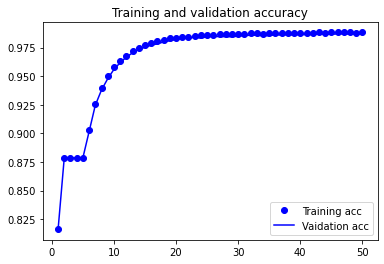

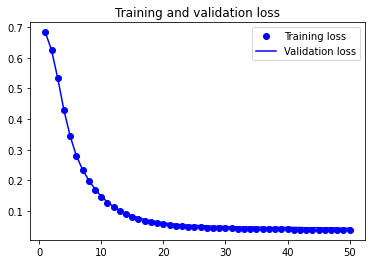

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7877045555064132
precision :  0.8338014981273408
recall :  0.7464375523889355
accuracy :  0.9512368568090618
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17301
           1       0.83      0.75      0.79      2386

    accuracy                           0.95     19687
   macro avg       0.90      0.86      0.88     19687
weighted avg       0.95      0.95      0.95     19687

[[16946   355]
 [  605  1781]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': None, 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 17301.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': None, 'class': '1', 'precision': 0.83, 'recall': 0.75, 'f1_score': 0.79, 'support': 2386.0, 'acc': 0.95}]

Evaluating on Hindi-Persian
f1-score :  0.7606837606837606
precision :  0.8090909090909091
recall :  0.717741935483871
accuracy :  0.9545085296506

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is reco

final report [{'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.98, 'recall': 0.97, 'f1_score': 0.98, 'support': 1636.0}, {'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.85, 'recall': 0.85, 'f1_score': 0.85, 'support': 266.0, 'acc': 0.96}]

Evaluating on Romanian-French
f1-score :  0.7724867724867726
precision :  0.8156424581005587
recall :  0.7336683417085427
accuracy :  0.9483173076923077
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1465
           1       0.82      0.73      0.77       199

    accuracy                           0.95      1664
   macro avg       0.89      0.86      0.87      1664
weighted avg       0.95      0.95      0.95      1664

[[1432   33]
 [  53  146]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair'

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 100
                    Train set - loss: 0.632, accuracy: 0.899 
                    Val set - loss: 0.633, accuracy: 0.899
epoch 200
                    Train set - loss: 0.543, accuracy: 0.899 
                    Val set - loss: 0.545, accuracy: 0.899
epoch 300
                    Train set - loss: 0.437, accuracy: 0.899 
                    Val set - loss: 0.442, accuracy: 0.899
epoch 400
                    Train set - loss: 0.348, accuracy: 0.899 
                    Val set - loss: 0.356, accuracy: 0.899
epoch 500
                    Train set - loss: 0.279, accuracy: 0.899 
                    Val set - loss: 0.291, accuracy: 0.899
epoch 600
                    Train set - loss: 0.227, accuracy: 0.914 
                    Val set - loss: 0.245, accuracy: 0.906
epoch 700
                    Train set - loss: 0.186, accuracy: 0.948 
                    Val set - loss: 0.211, accuracy: 0.931
epoch 800
                    Train set - loss: 0.156, accuracy: 0.961 
           

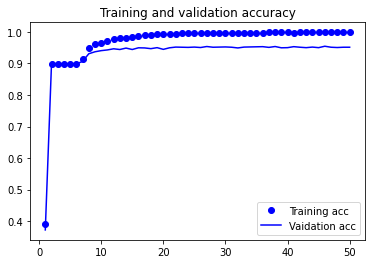

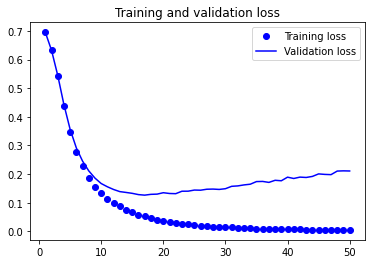

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7445887445887446
precision :  0.8037383177570093
recall :  0.6935483870967742
accuracy :  0.9520714865962632
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1107
           1       0.80      0.69      0.74       124

    accuracy                           0.95      1231
   macro avg       0.88      0.84      0.86      1231
weighted avg       0.95      0.95      0.95      1231

[[1086   21]
 [  38   86]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 1107.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.8, 'recall': 0.69, 'f1_score': 0.74, 'support': 124.0, 'acc': 0.95}]

Training and evaluating on English-French
epoch 0
                    Train set - loss: 0.679, accuracy: 0.805 
                   

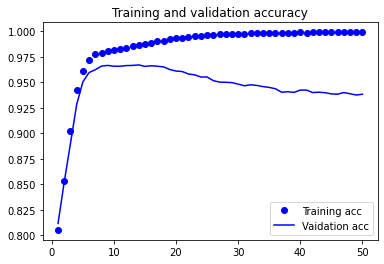

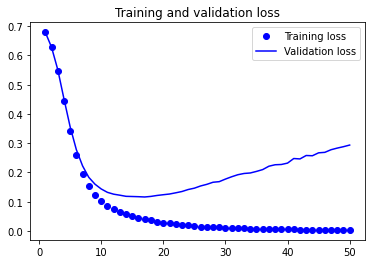

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7966976264189888
precision :  0.8354978354978355
recall :  0.7613412228796844
accuracy :  0.9423470880889669
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2910
           1       0.84      0.76      0.80       507

    accuracy                           0.94      3417
   macro avg       0.90      0.87      0.88      3417
weighted avg       0.94      0.94      0.94      3417

[[2834   76]
 [ 121  386]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.97, 'support': 2910.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.84, 'recall': 0.76, 'f1_score': 0.8, 'support': 507.0, 'acc': 0.94}]

Training and evaluating on Finnish-Swedish
epoch 0
                    Train set - loss: 0.679, accuracy: 0.888 
                

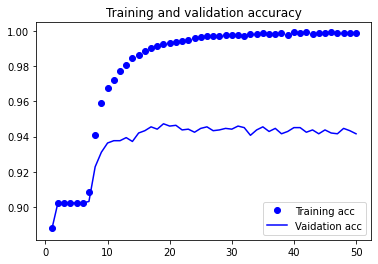

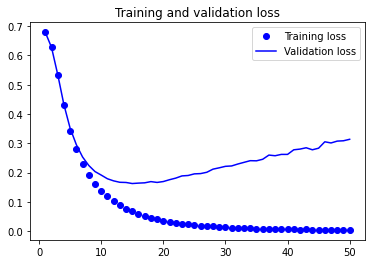

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.6168224299065419
precision :  0.7333333333333333
recall :  0.532258064516129
accuracy :  0.9354838709677419
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1147
           1       0.73      0.53      0.62       124

    accuracy                           0.94      1271
   macro avg       0.84      0.76      0.79      1271
weighted avg       0.93      0.94      0.93      1271

[[1123   24]
 [  58   66]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.95, 'recall': 0.98, 'f1_score': 0.96, 'support': 1147.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.73, 'recall': 0.53, 'f1_score': 0.62, 'support': 124.0, 'acc': 0.94}]

Training and evaluating on Kazakh-Russian
epoch 0
                    Train set - loss: 0.702, accuracy: 0.173 
               

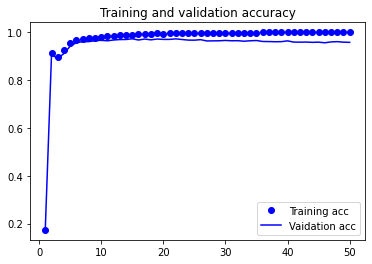

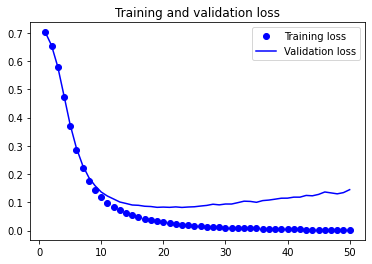

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7602339181286549
precision :  0.8024691358024691
recall :  0.7222222222222222
accuracy :  0.9464052287581699
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1350
           1       0.80      0.72      0.76       180

    accuracy                           0.95      1530
   macro avg       0.88      0.85      0.87      1530
weighted avg       0.94      0.95      0.95      1530

[[1318   32]
 [  50  130]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1350.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.8, 'recall': 0.72, 'f1_score': 0.76, 'support': 180.0, 'acc': 0.95}]

Training and evaluating on Azerbaijani-Arabic
epoch 0
                    Train set - loss: 0.745, accuracy: 0.093 
             

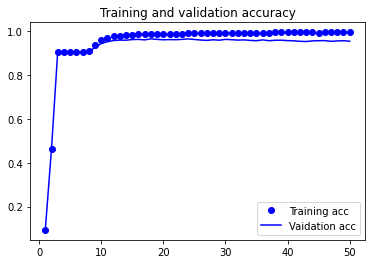

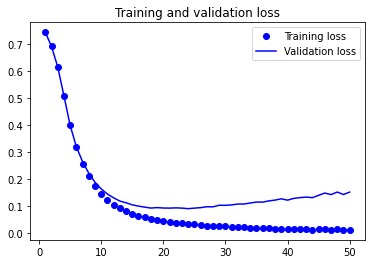

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.6893203883495146
precision :  0.7473684210526316
recall :  0.6396396396396397
accuracy :  0.9463986599664992
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1083
           1       0.75      0.64      0.69       111

    accuracy                           0.95      1194
   macro avg       0.86      0.81      0.83      1194
weighted avg       0.94      0.95      0.94      1194

[[1059   24]
 [  40   71]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1083.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 0.75, 'recall': 0.64, 'f1_score': 0.69, 'support': 111.0, 'acc': 0.95}]

Training and evaluating on Chinese-English
epoch 0
                    Train set - loss: 0.693, accuracy: 0.487 
       

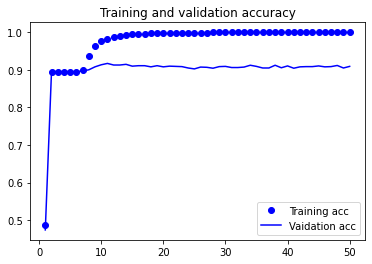

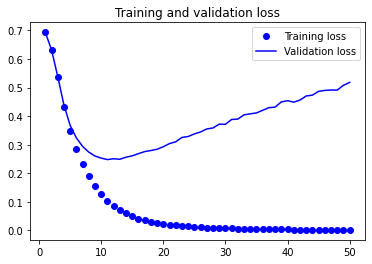

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.593939393939394
precision :  0.7
recall :  0.5157894736842106
accuracy :  0.9264544456641054
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       816
           1       0.70      0.52      0.59        95

    accuracy                           0.93       911
   macro avg       0.82      0.75      0.78       911
weighted avg       0.92      0.93      0.92       911

[[795  21]
 [ 46  49]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 816.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.7, 'recall': 0.52, 'f1_score': 0.59, 'support': 95.0, 'acc': 0.93}]

Training and evaluating on German-French
epoch 0
                    Train set - loss: 0.696, accuracy: 0.35 
                    Val set - loss: 0.6

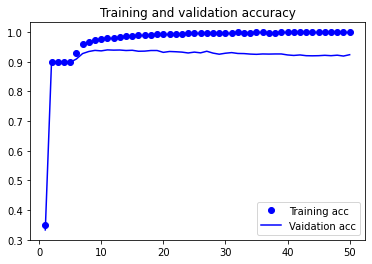

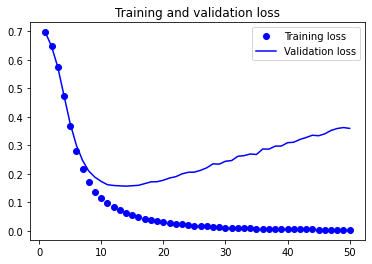

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.639344262295082
precision :  0.7222222222222222
recall :  0.5735294117647058
accuracy :  0.9340823970037453
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1199
           1       0.72      0.57      0.64       136

    accuracy                           0.93      1335
   macro avg       0.84      0.77      0.80      1335
weighted avg       0.93      0.93      0.93      1335

[[1169   30]
 [  58   78]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1199.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.72, 'recall': 0.57, 'f1_score': 0.64, 'support': 136.0, 'acc': 0.93}]

Training and evaluating on English-German
epoch 0
                    Train set - loss: 0.677, accuracy: 0.864 
                   

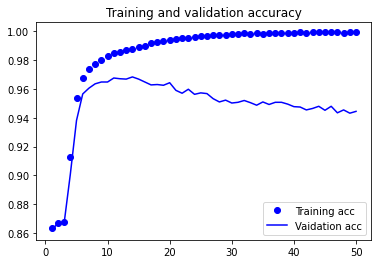

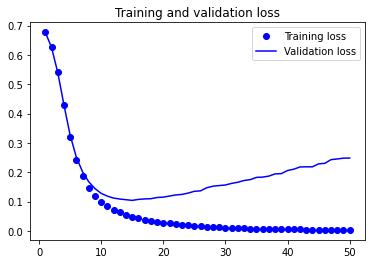

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.73992673992674
precision :  0.8015873015873016
recall :  0.6870748299319728
accuracy :  0.9356592659719075
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1913
           1       0.80      0.69      0.74       294

    accuracy                           0.94      2207
   macro avg       0.88      0.83      0.85      2207
weighted avg       0.93      0.94      0.93      2207

[[1863   50]
 [  92  202]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1913.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.8, 'recall': 0.69, 'f1_score': 0.74, 'support': 294.0, 'acc': 0.94}]

Training and evaluating on Romanian-Hungarian
epoch 0
                    Train set - loss: 0.668, accuracy: 0.892 
               

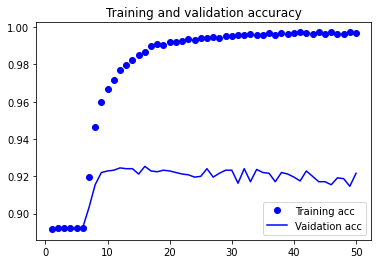

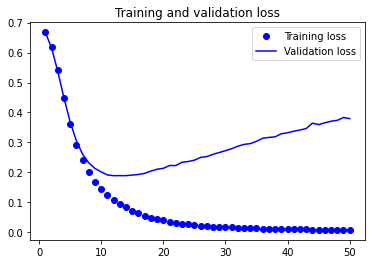

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.5931558935361216
precision :  0.6610169491525424
recall :  0.5379310344827586
accuracy :  0.9207407407407407
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1205
           1       0.66      0.54      0.59       145

    accuracy                           0.92      1350
   macro avg       0.80      0.75      0.77      1350
weighted avg       0.92      0.92      0.92      1350

[[1165   40]
 [  67   78]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1205.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.66, 'recall': 0.54, 'f1_score': 0.59, 'support': 145.0, 'acc': 0.92}]

Training and evaluating on Polish-French
epoch 0
                    Train set - loss: 0.679, accuracy: 0.86 
          

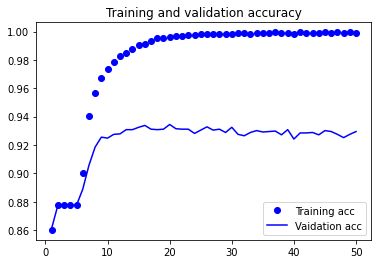

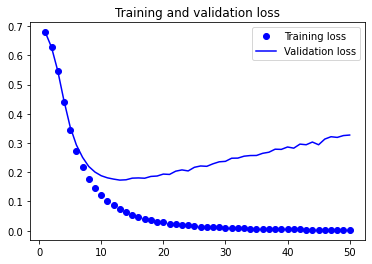

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.6961038961038961
precision :  0.7444444444444445
recall :  0.6536585365853659
accuracy :  0.9301492537313433
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1470
           1       0.74      0.65      0.70       205

    accuracy                           0.93      1675
   macro avg       0.85      0.81      0.83      1675
weighted avg       0.93      0.93      0.93      1675

[[1424   46]
 [  71  134]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1470.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.74, 'recall': 0.65, 'f1_score': 0.7, 'support': 205.0, 'acc': 0.93}]

Training and evaluating on Indonesian-Dutch
epoch 0
                    Train set - loss: 0.695, accuracy: 0.41 
                  

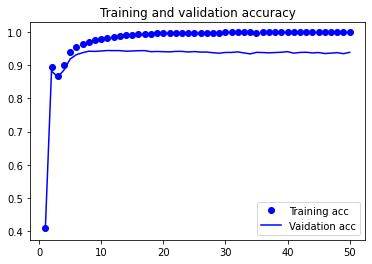

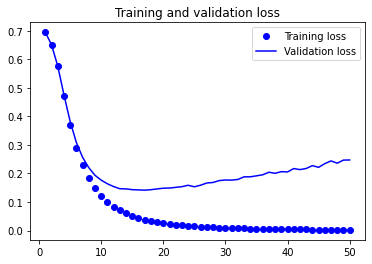

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7954545454545454
precision :  0.8015267175572519
recall :  0.7894736842105263
accuracy :  0.943217665615142
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1636
           1       0.80      0.79      0.80       266

    accuracy                           0.94      1902
   macro avg       0.88      0.88      0.88      1902
weighted avg       0.94      0.94      0.94      1902

[[1584   52]
 [  56  210]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.97, 'recall': 0.97, 'f1_score': 0.97, 'support': 1636.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.8, 'recall': 0.79, 'f1_score': 0.8, 'support': 266.0, 'acc': 0.94}]

Training and evaluating on Romanian-French
epoch 0
                    Train set - loss: 0.681, accuracy: 0.861 
              

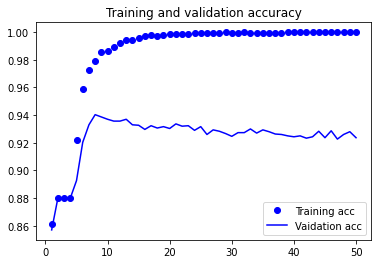

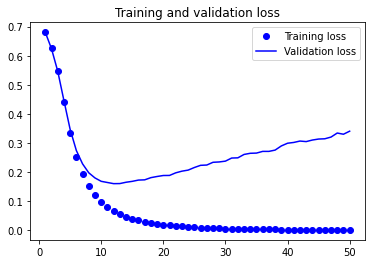

f1-score :  0.6703296703296703
precision :  0.7393939393939394
recall :  0.6130653266331658
accuracy :  0.9278846153846154
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1465
           1       0.74      0.61      0.67       199

    accuracy                           0.93      1664
   macro avg       0.84      0.79      0.81      1664
weighted avg       0.92      0.93      0.92      1664

[[1422   43]
 [  77  122]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1465.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.74, 'recall': 0.61, 'f1_score': 0.67, 'support': 199.0, 'acc': 0.93}]

Exists


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [28]:
print("Evaluating on alldata splits\n")
#nn_evaluate(train_alldata, test_alldata, pairs)


print("Evaluating and Saving final results as csv files on alldata splits\n")
output_alldata,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = nn_evaluate(train_alldata, test_alldata, pairs)
prefix = f'../Final_results/all_data/NN_results'

#prefix = f'../Final_results/all_data/features_wo_dnnlogits_cosims/NN_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_alldata.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')

# print("Evaluating on realdist splits\n")
# nn_evaluate(train_realdist, test_realdist, pairs)

# print("Evaluating on balanced splits\n")
# nn_evaluate(train_balanced, test_balanced, pairs)

# NN real dist

Evaluating on realdist splits

Evaluating and Saving final results as csv files on realdist splits

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=34, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)
Training on all langs

epoch 0
                    Train set - loss: 0.689, accuracy: 0.704 
                    Val set - loss: 0.689, accuracy: 0.708
epoch 100
                    Train set - loss: 0.642, accuracy: 0.792 
                    Val set - loss: 0.642, accuracy: 0.792
epoch 200
                    Train set - loss: 0.564, accuracy: 0.804 
                    Val set - loss: 0.563, accuracy: 0.805
epoch 300
          

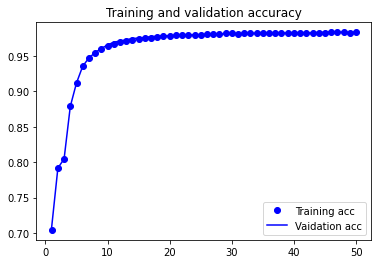

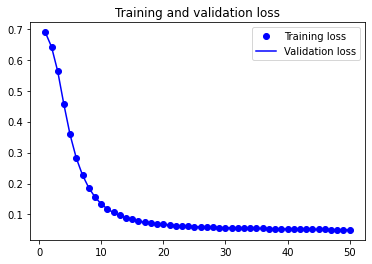

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recom

f1-score :  0.8633928571428571
precision :  0.9235912129894938
recall :  0.8105616093880972
accuracy :  0.9617236850334605
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13603
           1       0.92      0.81      0.86      2386

    accuracy                           0.96     15989
   macro avg       0.95      0.90      0.92     15989
weighted avg       0.96      0.96      0.96     15989

[[13443   160]
 [  452  1934]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': None, 'class': '0', 'precision': 0.97, 'recall': 0.99, 'f1_score': 0.98, 'support': 13603.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': None, 'class': '1', 'precision': 0.92, 'recall': 0.81, 'f1_score': 0.86, 'support': 2386.0, 'acc': 0.96}]

Evaluating on Hindi-Persian
f1-score :  0.8991596638655464
precision :  0.9385964912280702
recall :  0.8629032258064516
accuracy :  0.942028985507

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: To copy construct from a tensor, it is reco

epoch 100
                    Train set - loss: 0.641, accuracy: 0.938 
                    Val set - loss: 0.641, accuracy: 0.929
epoch 200
                    Train set - loss: 0.562, accuracy: 0.94 
                    Val set - loss: 0.562, accuracy: 0.932
epoch 300
                    Train set - loss: 0.454, accuracy: 0.944 
                    Val set - loss: 0.453, accuracy: 0.939
epoch 400
                    Train set - loss: 0.349, accuracy: 0.951 
                    Val set - loss: 0.348, accuracy: 0.943
epoch 500
                    Train set - loss: 0.268, accuracy: 0.953 
                    Val set - loss: 0.268, accuracy: 0.949
epoch 600
                    Train set - loss: 0.211, accuracy: 0.96 
                    Val set - loss: 0.213, accuracy: 0.955
epoch 700
                    Train set - loss: 0.174, accuracy: 0.964 
                    Val set - loss: 0.176, accuracy: 0.957
epoch 800
                    Train set - loss: 0.146, accuracy: 0.966 
             

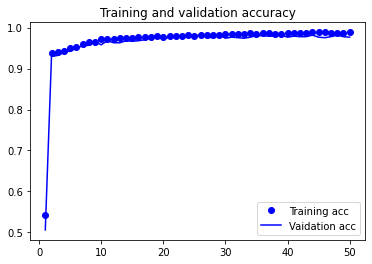

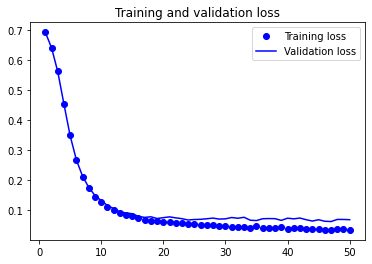

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.9288702928870292
precision :  0.9652173913043478
recall :  0.8951612903225806
accuracy :  0.9589371980676329
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       290
           1       0.97      0.90      0.93       124

    accuracy                           0.96       414
   macro avg       0.96      0.94      0.95       414
weighted avg       0.96      0.96      0.96       414

[[286   4]
 [ 13 111]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 290.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.97, 'recall': 0.9, 'f1_score': 0.93, 'support': 124.0, 'acc': 0.96}]

Training and evaluating on English-French
epoch 0
                    Train set - loss: 0.687, accuracy: 0.66 
                    Val s

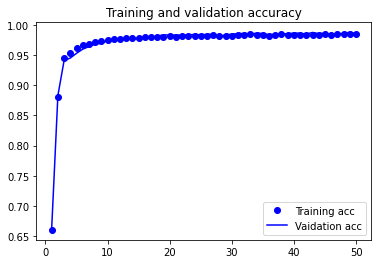

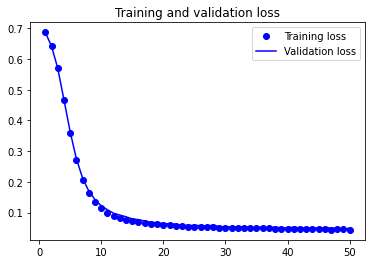

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.9392712550607288
precision :  0.9646569646569647
recall :  0.9151873767258383
accuracy :  0.9644970414201184
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1183
           1       0.96      0.92      0.94       507

    accuracy                           0.96      1690
   macro avg       0.96      0.95      0.96      1690
weighted avg       0.96      0.96      0.96      1690

[[1166   17]
 [  43  464]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 1183.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.96, 'recall': 0.92, 'f1_score': 0.94, 'support': 507.0, 'acc': 0.96}]

Training and evaluating on Finnish-Swedish
epoch 0
                    Train set - loss: 0.681, accuracy: 0.856 
               

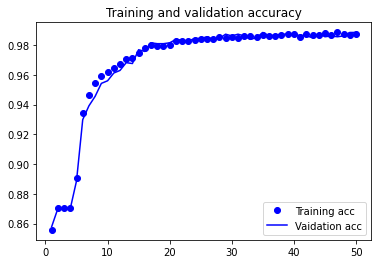

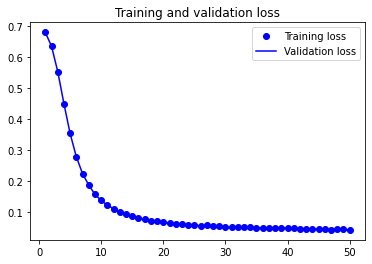

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7222222222222221
precision :  0.8478260869565217
recall :  0.6290322580645161
accuracy :  0.951651893634166
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1117
           1       0.85      0.63      0.72       124

    accuracy                           0.95      1241
   macro avg       0.90      0.81      0.85      1241
weighted avg       0.95      0.95      0.95      1241

[[1103   14]
 [  46   78]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 1117.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.85, 'recall': 0.63, 'f1_score': 0.72, 'support': 124.0, 'acc': 0.95}]

Training and evaluating on Kazakh-Russian
epoch 0
                    Train set - loss: 0.7, accuracy: 0.227 
                 

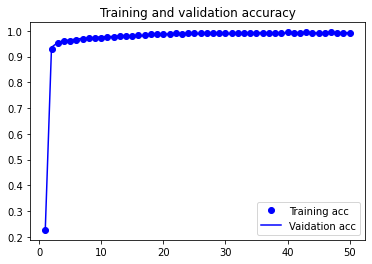

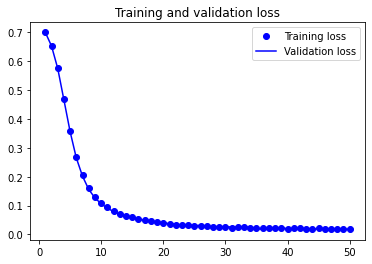

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.9209039548022598
precision :  0.9367816091954023
recall :  0.9055555555555556
accuracy :  0.9844961240310077
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1626
           1       0.94      0.91      0.92       180

    accuracy                           0.98      1806
   macro avg       0.96      0.95      0.96      1806
weighted avg       0.98      0.98      0.98      1806

[[1615   11]
 [  17  163]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.99, 'recall': 0.99, 'f1_score': 0.99, 'support': 1626.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.94, 'recall': 0.91, 'f1_score': 0.92, 'support': 180.0, 'acc': 0.98}]

Training and evaluating on Azerbaijani-Arabic
epoch 0
                    Train set - loss: 0.736, accuracy: 0.157 
            

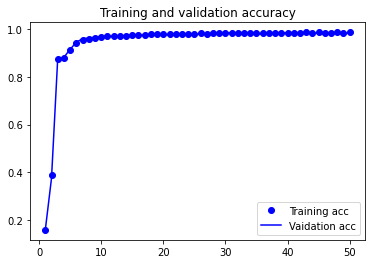

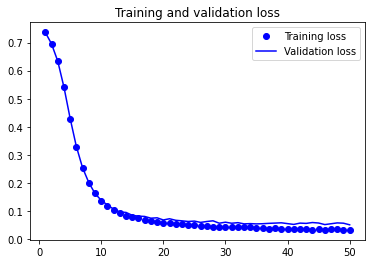

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.8405797101449275
precision :  0.90625
recall :  0.7837837837837838
accuracy :  0.9554655870445344
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       630
           1       0.91      0.78      0.84       111

    accuracy                           0.96       741
   macro avg       0.93      0.88      0.91       741
weighted avg       0.95      0.96      0.95       741

[[621   9]
 [ 24  87]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 630.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 0.91, 'recall': 0.78, 'f1_score': 0.84, 'support': 111.0, 'acc': 0.96}]

Training and evaluating on Chinese-English
epoch 0
                    Train set - loss: 0.694, accuracy: 0.449 
                    Val

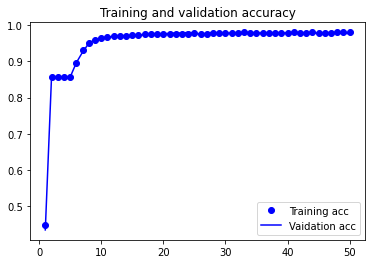

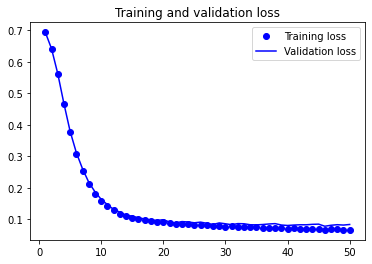

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.6904761904761905
precision :  0.7945205479452054
recall :  0.6105263157894737
accuracy :  0.9456066945606695
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       861
           1       0.79      0.61      0.69        95

    accuracy                           0.95       956
   macro avg       0.88      0.80      0.83       956
weighted avg       0.94      0.95      0.94       956

[[846  15]
 [ 37  58]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 861.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.79, 'recall': 0.61, 'f1_score': 0.69, 'support': 95.0, 'acc': 0.95}]

Training and evaluating on German-French
epoch 0
                    Train set - loss: 0.695, accuracy: 0.369 
                    V

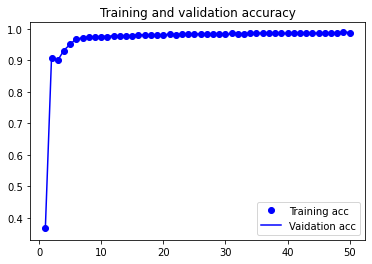

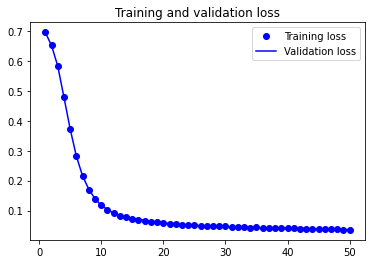

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.8837209302325582
precision :  0.9344262295081968
recall :  0.8382352941176471
accuracy :  0.9779735682819384
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1226
           1       0.93      0.84      0.88       136

    accuracy                           0.98      1362
   macro avg       0.96      0.92      0.94      1362
weighted avg       0.98      0.98      0.98      1362

[[1218    8]
 [  22  114]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.99, 'support': 1226.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.93, 'recall': 0.84, 'f1_score': 0.88, 'support': 136.0, 'acc': 0.98}]

Training and evaluating on English-German
epoch 0
                    Train set - loss: 0.681, accuracy: 0.789 
                  

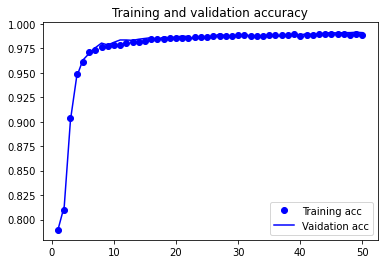

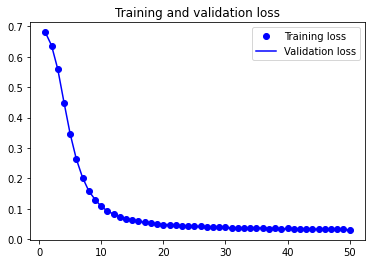

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.9081272084805654
precision :  0.9448529411764706
recall :  0.8741496598639455
accuracy :  0.9823189391363482
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2647
           1       0.94      0.87      0.91       294

    accuracy                           0.98      2941
   macro avg       0.97      0.93      0.95      2941
weighted avg       0.98      0.98      0.98      2941

[[2632   15]
 [  37  257]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.99, 'recall': 0.99, 'f1_score': 0.99, 'support': 2647.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.94, 'recall': 0.87, 'f1_score': 0.91, 'support': 294.0, 'acc': 0.98}]

Training and evaluating on Romanian-Hungarian
epoch 0
                    Train set - loss: 0.671, accuracy: 0.853 
            

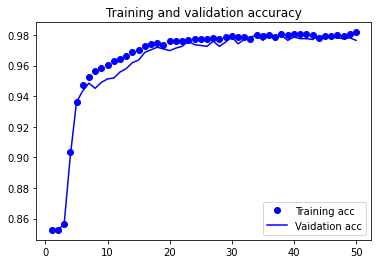

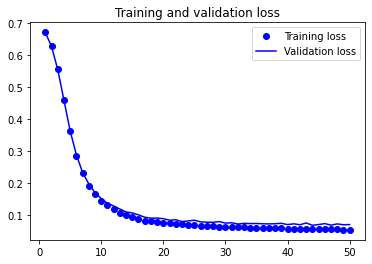

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.7335907335907337
precision :  0.8333333333333334
recall :  0.6551724137931034
accuracy :  0.9526424159231297
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1312
           1       0.83      0.66      0.73       145

    accuracy                           0.95      1457
   macro avg       0.90      0.82      0.85      1457
weighted avg       0.95      0.95      0.95      1457

[[1293   19]
 [  50   95]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 1312.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.83, 'recall': 0.66, 'f1_score': 0.73, 'support': 145.0, 'acc': 0.95}]

Training and evaluating on Polish-French
epoch 0
                    Train set - loss: 0.684, accuracy: 0.802 
         

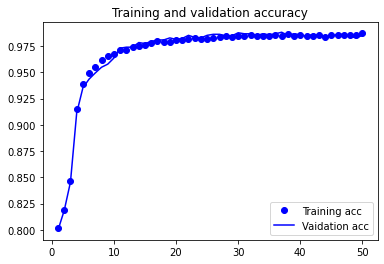

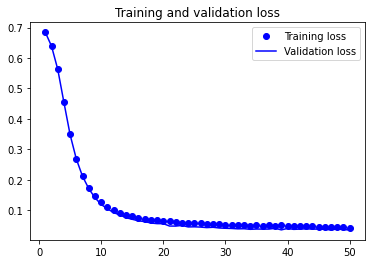

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.8311688311688312
precision :  0.8888888888888888
recall :  0.7804878048780488
accuracy :  0.9683235867446394
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1847
           1       0.89      0.78      0.83       205

    accuracy                           0.97      2052
   macro avg       0.93      0.88      0.91      2052
weighted avg       0.97      0.97      0.97      2052

[[1827   20]
 [  45  160]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.98, 'support': 1847.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.89, 'recall': 0.78, 'f1_score': 0.83, 'support': 205.0, 'acc': 0.97}]

Training and evaluating on Indonesian-Dutch
epoch 0
                    Train set - loss: 0.687, accuracy: 0.612 
                

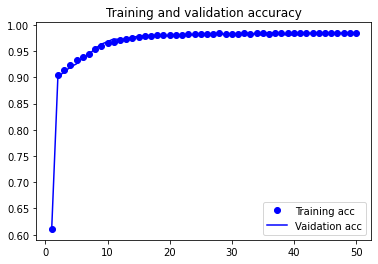

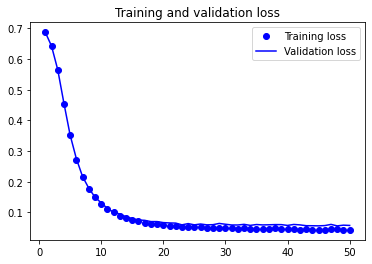

/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


f1-score :  0.9366602687140115
precision :  0.9568627450980393
recall :  0.9172932330827067
accuracy :  0.9503759398496241
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       399
           1       0.96      0.92      0.94       266

    accuracy                           0.95       665
   macro avg       0.95      0.94      0.95       665
weighted avg       0.95      0.95      0.95       665

[[388  11]
 [ 22 244]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 399.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.96, 'recall': 0.92, 'f1_score': 0.94, 'support': 266.0, 'acc': 0.95}]

Training and evaluating on Romanian-French
epoch 0
                    Train set - loss: 0.685, accuracy: 0.729 
                

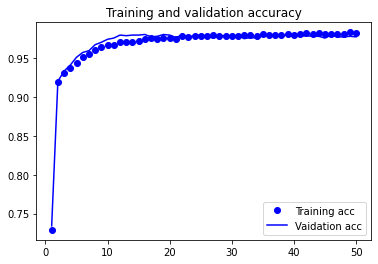

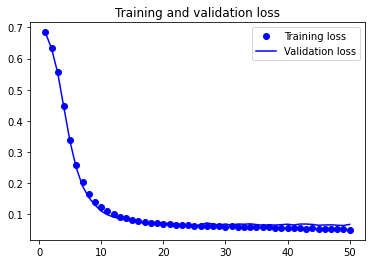

f1-score :  0.9086161879895561
precision :  0.9456521739130435
recall :  0.8743718592964824
accuracy :  0.947289156626506
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       465
           1       0.95      0.87      0.91       199

    accuracy                           0.95       664
   macro avg       0.95      0.93      0.94       664
weighted avg       0.95      0.95      0.95       664

[[455  10]
 [ 25 174]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.95, 'recall': 0.98, 'f1_score': 0.96, 'support': 465.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.95, 'recall': 0.87, 'f1_score': 0.91, 'support': 199.0, 'acc': 0.95}]

Exists


/s/chopin/d/proj/ramfis-aida/venv/lib/python3.6/site-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [29]:
print("Evaluating on realdist splits\n")
 
print("Evaluating and Saving final results as csv files on realdist splits\n")
output_realdist,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = nn_evaluate(train_realdist, test_realdist, pairs)
prefix = f'../Final_results/real_dist/NN_results'
#prefix = f'../Final_results/real_dist/features_wo_dnnlogits_cosims/NN_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_realdist.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')

# NN balanced

In [ ]:
print("Evaluating on balanced splits\n")
 
print("Evaluating and Saving final results as csv files on balanced splits\n")
output_balanced,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = nn_evaluate(train_balanced, test_balanced, pairs)
#prefix = f'../Final_results/balanced/NN_results'
prefix = f'../Final_results/balanced/features_wo_dnnlogits_cosims/NN_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_balanced.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')

# final results Pruned list

In [ ]:
train_realdist_pruned = {}

# remove any pairs in alldata testing set from realdist training set
for lang in train_realdist:
    train_realdist_pruned[lang] = train_realdist[lang][~train_realdist[lang].set_index(['loan_word','original_word']).index.\
                          isin(test_alldata[lang].set_index(['loan_word','original_word']).index)]

print("Evaluating on realdist (train) and alldata (test)\n")
output_pruned,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = nn_evaluate(train_realdist_pruned, test_alldata, pairs)
#prefix = f'../Final_results/pruned_nn'

prefix = f'../Final_results/pruned_nn/features_wo_dnnlogits_cosims/NN_results'

if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_pruned.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')





In [ ]:
def nn_evaluate_holdout(full_train_set, full_holdout_test_set, holdout_pairs_list):  
    all_result_nn_holdout = []
    hold_out_fp=[]
    hold_out_fn =[]
    pair =None #pair None for all languages evaluation
    display_fields = ['loan_word',
              'original_word',
              'loan_word_epitran',
              'original_word_epitran',
              'loan_english',
              'original_english'] + features
        
    train_set = pd.concat([full_train_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    x_stds[x_stds == 0] = 1
    y_train = train_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds
    
    torch.manual_seed(7)
    random.seed(7)
    np.random.seed(7)
    
    model = NeuralNetwork(x_train.shape[1]).to(device)
    print(model)
    
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    #optimizer = optim.SGD(model.parameters(),lr=0.00001, momentum=0.0,  weight_decay=0.0, nesterov=False)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1, stratify=y_train)

    x_train = torch.tensor(x_train).to(device)
    x_val = torch.tensor(x_val).to(device)
    y_train = torch.tensor(y_train).reshape(-1,1).to(device)
    y_val = torch.tensor(y_val).reshape(-1,1).to(device)
        
    print("Training on all langs\n")
    train_losses, val_losses, train_accur, val_accur = \
        model.fit(x_train, y_train, x_val, y_val, criterion, optimizer, n_epochs=5000)
    model.plot_losses(train_losses,val_losses,train_accur,val_accur)
    
    model.eval()

    with torch.no_grad():
        for pair in holdout_pairs_list:
            print(f'Evaluating on {pair}')

            test_set = full_holdout_test_set[pair][display_fields + ["label"] + labels]
            x_test = test_set[features].values
            y_test = test_set[labels].values.ravel()

            x_test = (x_test - x_means)/x_stds
            x_test = torch.tensor(x_test).to(device)
            y_pred = model(torch.tensor(x_test).float())[0] > .5
            y_pred = y_pred.detach().cpu().numpy()
             
            print("f1-score : ", f1_score(y_test, y_pred ))
            print("precision : ",precision_score(y_test, y_pred))
            print("recall : ",recall_score(y_test, y_pred )) 
            print("accuracy : ",accuracy_score(y_test, y_pred))
            print(classification_report(y_test, y_pred))
            print(confusion_matrix(y_test, y_pred))
            class_report = classification_report(y_test, y_pred)
            a = classification_report_csv(class_report,pair,all_lang=False, train_evaluate_pair =False)
            all_result_nn_holdout.append(a)
            print()
            
            # display false positives and false negatives
            unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
            tp = np.array(np.where(unq == 3)).tolist()[0]
            fp = np.array(np.where(unq == 1)).tolist()[0]
            tn = np.array(np.where(unq == 0)).tolist()[0]
            fn = np.array(np.where(unq == 2)).tolist()[0]

            display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
            display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
            holdout_evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
            holdout_evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
            #holdout_evaluate_lang_fp['language_pair'] = pair
            #holdout_evaluate_lang_fn['language_pair'] = pair
            holdout_evaluate_lang_fp.insert(0, 'language_pair', pair)
            holdout_evaluate_lang_fn.insert(0, 'language_pair', pair)
            hold_out_fp.append(holdout_evaluate_lang_fp)
            hold_out_fn.append(holdout_evaluate_lang_fn)
    holdout_evaluate_lang_fp = pd.concat(hold_out_fp, ignore_index=True) 
    holdout_evaluate_lang_fn = pd.concat(hold_out_fn, ignore_index=True) 
    final_result = pd.concat(all_result_nn_holdout, ignore_index=True)
    return final_result, holdout_evaluate_lang_fp,holdout_evaluate_lang_fn
            

In [ ]:
with open('../language-pairs-holdout.json', 'r') as f:
    pairs_holdout = json.loads(f.read())
    print(pairs_holdout)
    
test_holdout_alldata = {}

test_holdout_realdist = {}

test_holdout_balanced = {}

for pair in pairs_holdout:
    print(pair)
    L1 = pairs_holdout[pair]['target']['name']
    L2 = pairs_holdout[pair]['source']['name']

    # load datasets
    prefix = f'../Datasets/production_train_test/{L1}-{L2}'

    test_holdout_alldata[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/alldata/{L1}-{L2}-test_production_alldata.csv')

    test_holdout_realdist[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/realdist/{L1}-{L2}-test_production_realdist.csv')

    test_holdout_balanced[f'{L1}-{L2}'] = pd.read_csv(f'{prefix}/balanced/{L1}-{L2}-test_production_balanced.csv')
    
for pair in pairs_holdout:
    # all data
    loan_unicode_onehots = pd.DataFrame(test_holdout_alldata[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(test_holdout_alldata[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    test_holdout_alldata[pair] = pd.concat([test_holdout_alldata[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
    
    # real dist            
    loan_unicode_onehots = pd.DataFrame(test_holdout_realdist[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(test_holdout_realdist[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    test_holdout_realdist[pair] = pd.concat([test_holdout_realdist[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
    
    # balanced
    loan_unicode_onehots = pd.DataFrame(test_holdout_balanced[pair]['loan_unicode'].map(unicode_map).tolist(), \
                     columns = [f'loan_unicode_{l[0]}' for l in unicode_list])
    orig_unicode_onehots = pd.DataFrame(test_holdout_balanced[pair]['original_unicode'].map(unicode_map).tolist(), \
                     columns = [f'original_unicode_{l[0]}' for l in unicode_list])
    test_holdout_balanced[pair] = pd.concat([test_holdout_balanced[pair], loan_unicode_onehots, orig_unicode_onehots], axis=1)
    


In [ ]:
print("Evaluating on alldata splits\n")
output_holdout, holdout_evaluate_lang_fp,holdout_evaluate_lang_fn = nn_evaluate_holdout(train_alldata, test_holdout_alldata, pairs_holdout)

#prefix = f'../Final_results/holdout/all_data'
prefix = f'../Final_results/holdout/all_data/features_wo_dnnlogits_cosims'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_holdout.to_csv(f'{prefix}/holdout_final_results.csv')
holdout_evaluate_lang_fp.to_csv(f'{prefix}/holdout_falsepos.csv')
holdout_evaluate_lang_fn.to_csv(f'{prefix}/holdout_falseneg.csv')
 
# print("Evaluating on realdist splits\n")
# nn_evaluate_holdout(train_realdist, test_holdout_realdist, pairs_holdout)

# print("Evaluating on balanced splits\n")
# nn_evaluate_holdout(train_balanced, test_holdout_balanced, pairs_holdout)

In [ ]:
print("Evaluating on real dist splits\n")
output_holdout, holdout_evaluate_lang_fp,holdout_evaluate_lang_fn = nn_evaluate_holdout(train_realdist, test_holdout_realdist, pairs_holdout)

#prefix = f'../Final_results/holdout/real_dist'
prefix = f'../Final_results/holdout/real_dist/features_wo_dnnlogits_cosims'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_holdout.to_csv(f'{prefix}/holdout_final_results.csv')
holdout_evaluate_lang_fp.to_csv(f'{prefix}/holdout_falsepos.csv')
holdout_evaluate_lang_fn.to_csv(f'{prefix}/holdout_falseneg.csv')

In [ ]:
print("Evaluating on balanced splits\n")
output_holdout, holdout_evaluate_lang_fp,holdout_evaluate_lang_fn = nn_evaluate_holdout(train_balanced, test_holdout_balanced, pairs_holdout)

#prefix = f'../Final_results/holdout/balanced'
prefix = f'../Final_results/holdout/balanced/features_wo_dnnlogits_cosims'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_holdout.to_csv(f'{prefix}/holdout_final_results.csv')
holdout_evaluate_lang_fp.to_csv(f'{prefix}/holdout_falsepos.csv')
holdout_evaluate_lang_fn.to_csv(f'{prefix}/holdout_falseneg.csv')

# SVM Classifier

In [70]:
def svm_evaluate(full_train_set, full_test_set, pairs_list):
    pair ='All_languages'
    
    all_result = []
    all_lang_fp_list= []
    all_lang_fn_list=[]
    evaluate_lang_fp_list = []
    evaluate_lang_fn_list = []
    train_evaluate_lang_fp_list = []
    train_evaluate_lang_fn_list = []
    weights_list = []
    display_fields = ['loan_word',
              'original_word',
              'loan_word_epitran',
              'original_word_epitran',
              'loan_english',
              'original_english'] + features
        
    train_set = pd.concat([full_train_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    x_stds[x_stds == 0] = 1
    y_train = train_set[labels].values.ravel()
    
    test_set = pd.concat([full_test_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_test = test_set[features].values
    y_test = test_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds

    print("Training on all langs\n")
     
    SVM = SVC(kernel='linear')
    SVM.fit(x_train, y_train)

    # display regressor weights
    df = pd.DataFrame(SVM.coef_, columns=features).style.set_caption('Weights')
    df_weights = pd.DataFrame(SVM.coef_, columns=features) 
     
    df_weights.insert(0, 'language_pair', pair)
    
    weights_list.append(df_weights)
    display(df)
    print()
    
    print("Evaluating on all langs")
    x_test = (x_test - x_means)/x_stds
    y_pred = SVM.predict(x_test)

    print("f1-score : ", f1_score(y_test, y_pred ))
    print("precision : ",precision_score(y_test, y_pred))
    print("recall : ",recall_score(y_test, y_pred )) 
    print("accuracy : ",accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    class_report = classification_report(y_test, y_pred)
    a = classification_report_csv(class_report,pair,all_lang=True, train_evaluate_pair =False)
    all_result.append(a)
    print()
    
    # display false positives and false negatives
    unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
    tp = np.array(np.where(unq == 3)).tolist()[0]
    fp = np.array(np.where(unq == 1)).tolist()[0]
    tn = np.array(np.where(unq == 0)).tolist()[0]
    fn = np.array(np.where(unq == 2)).tolist()[0]

    #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
    #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
    all_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
    all_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
    
    all_lang_fp.insert(0, 'language_pair', pair)
    all_lang_fn.insert(0, 'language_pair', pair)
    all_lang_fp_list.append(all_lang_fp)
    all_lang_fn_list.append(all_lang_fn)
    
    for pair in pairs_list:
        print(f'Evaluating on {pair}')
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_test = (x_test - x_means)/x_stds
        y_pred = SVM.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=False, train_evaluate_pair =False)
        all_result.append(a)
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]] .style.set_caption('False negatives'))
        evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        
        evaluate_lang_fp.insert(0, 'language_pair', pair)
        evaluate_lang_fn.insert(0, 'language_pair', pair)
        evaluate_lang_fp_list.append(evaluate_lang_fp)
        evaluate_lang_fn_list.append(evaluate_lang_fn)
    for pair in pairs_list:
        print(f'Training and evaluating on {pair}')
        
        train_set = full_train_set[pair][display_fields + ["label"] + labels]
        x_train = train_set[features].values
        x_means = np.mean(x_train, axis=0)
        x_stds = np.std(x_train, axis=0)
        x_stds[x_stds == 0] = 1
        y_train = train_set[labels].values.ravel()
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_train = (x_train - x_means)/x_stds
        
        SVM = SVC(kernel='linear')
        SVM.fit(x_train, y_train)
        
        # display regressor weights
        df = pd.DataFrame(SVM.coef_, columns=features).style.set_caption('Weights')
        df_weights = pd.DataFrame(SVM.coef_, columns=features) 
     
        df_weights.insert(0, 'language_pair', pair)
    
        weights_list.append(df_weights)
        display(df)

        x_test = (x_test - x_means)/x_stds
        y_pred = SVM.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=False,train_evaluate_pair =True)
        all_result.append(a)
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        #display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        #display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
        train_evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        train_evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        
        train_evaluate_lang_fp.insert(0, 'language_pair', pair)
        train_evaluate_lang_fn.insert(0, 'language_pair', pair)
        train_evaluate_lang_fp_list.append(train_evaluate_lang_fp)
        train_evaluate_lang_fn_list.append(train_evaluate_lang_fn)
    
    final_result = pd.concat(all_result, ignore_index=True)
    all_lang_fp_list = pd.concat(all_lang_fp_list, ignore_index=True)
    all_lang_fn_list = pd.concat(all_lang_fn_list, ignore_index=True)
    evaluate_lang_fp_list = pd.concat(evaluate_lang_fp_list, ignore_index=True)
    evaluate_lang_fn_list = pd.concat(evaluate_lang_fn_list, ignore_index=True)
    train_evaluate_lang_fp_list = pd.concat(train_evaluate_lang_fp_list, ignore_index=True)
    train_evaluate_lang_fn_list = pd.concat(train_evaluate_lang_fn_list, ignore_index=True)
    weights = pd.concat(weights_list, ignore_index=True)
    
    return final_result, all_lang_fp_list, all_lang_fn_list, evaluate_lang_fp_list, evaluate_lang_fn_list, train_evaluate_lang_fp_list, train_evaluate_lang_fn_list, weights
        
        

In [71]:
print("Evaluating on alldata splits\n")
final_result,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn, weights = svm_evaluate(train_alldata, test_alldata, pairs)

#prefix = f'../Final_results/all_data/SVM_results'
#prefix = f'../Final_results/all_data/features_wo_dnnlogits_cosims/SVM_results'
prefix = f'../Final_results/all_data/logits_cosim_plainlev/SVM_results'
#prefix = f'../Final_results/all_data/logits_cosim/SVM_results'

if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
final_result.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')   
weights.to_csv(f'{prefix}/SVM_weights.csv')
# print("Evaluating on realdist splits\n")
# svm_evaluate(train_realdist, test_realdist, pairs)

# print("Evaluating on balanced splits\n")
# svm_evaluate(train_balanced, test_balanced, pairs)

Evaluating on alldata splits

Training on all langs



,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.387381,3.586515,0.071878,0.182416



Evaluating on all langs
f1-score :  0.730194153090828
precision :  0.7809069212410501
recall :  0.6856663872590109
accuracy :  0.9385889165439122
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     17301
           1       0.78      0.69      0.73      2386

    accuracy                           0.94     19687
   macro avg       0.87      0.83      0.85     19687
weighted avg       0.94      0.94      0.94     19687

[[16842   459]
 [  750  1636]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All_languages', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.97, 'support': 17301.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All_languages', 'class': '1', 'precision': 0.78, 'recall': 0.69, 'f1_score': 0.73, 'support': 2386.0, 'acc': 0.94}]

Evaluating on Hindi-Persian
f1-score :  0.7123287671232877
precision :  0.8210526315789474
recall : 

f1-score :  0.6984126984126984
precision :  0.7630057803468208
recall :  0.6439024390243903
accuracy :  0.9319402985074627
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1470
           1       0.76      0.64      0.70       205

    accuracy                           0.93      1675
   macro avg       0.86      0.81      0.83      1675
weighted avg       0.93      0.93      0.93      1675

[[1429   41]
 [  73  132]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1470.0}, {'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.76, 'recall': 0.64, 'f1_score': 0.7, 'support': 205.0, 'acc': 0.93}]

Evaluating on Indonesian-Dutch
f1-score :  0.8215613382899629
precision :  0.8125
recall :  0.8308270676691729
accuracy :  0.9495

,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,0.135837,4.403992,-0.003368,0.111732


f1-score :  0.7272727272727273
precision :  0.7850467289719626
recall :  0.6774193548387096
accuracy :  0.9488220958570268
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1107
           1       0.79      0.68      0.73       124

    accuracy                           0.95      1231
   macro avg       0.87      0.83      0.85      1231
weighted avg       0.95      0.95      0.95      1231

[[1084   23]
 [  40   84]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1107.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.79, 'recall': 0.68, 'f1_score': 0.73, 'support': 124.0, 'acc': 0.95}]

Training and evaluating on English-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.046049,2.566719,0.205479,0.514454


f1-score :  0.8839556004036326
precision :  0.9049586776859504
recall :  0.863905325443787
accuracy :  0.9663447468539654
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2910
           1       0.90      0.86      0.88       507

    accuracy                           0.97      3417
   macro avg       0.94      0.92      0.93      3417
weighted avg       0.97      0.97      0.97      3417

[[2864   46]
 [  69  438]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.98, 'recall': 0.98, 'f1_score': 0.98, 'support': 2910.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.9, 'recall': 0.86, 'f1_score': 0.88, 'support': 507.0, 'acc': 0.97}]

Training and evaluating on Finnish-Swedish


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.536923,3.614878,0.056987,0.072073


f1-score :  0.6226415094339622
precision :  0.75
recall :  0.532258064516129
accuracy :  0.9370574350904799
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1147
           1       0.75      0.53      0.62       124

    accuracy                           0.94      1271
   macro avg       0.85      0.76      0.79      1271
weighted avg       0.93      0.94      0.93      1271

[[1125   22]
 [  58   66]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.95, 'recall': 0.98, 'f1_score': 0.97, 'support': 1147.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.75, 'recall': 0.53, 'f1_score': 0.62, 'support': 124.0, 'acc': 0.94}]

Training and evaluating on Kazakh-Russian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.985529,4.721805,-0.091379,0.051354


f1-score :  0.8295454545454545
precision :  0.8488372093023255
recall :  0.8111111111111111
accuracy :  0.9607843137254902
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1350
           1       0.85      0.81      0.83       180

    accuracy                           0.96      1530
   macro avg       0.91      0.90      0.90      1530
weighted avg       0.96      0.96      0.96      1530

[[1324   26]
 [  34  146]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.98, 'support': 1350.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.85, 'recall': 0.81, 'f1_score': 0.83, 'support': 180.0, 'acc': 0.96}]

Training and evaluating on Azerbaijani-Arabic


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,0.796189,4.175907,-0.267671,0.013749


f1-score :  0.6824644549763034
precision :  0.72
recall :  0.6486486486486487
accuracy :  0.9438860971524288
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1083
           1       0.72      0.65      0.68       111

    accuracy                           0.94      1194
   macro avg       0.84      0.81      0.83      1194
weighted avg       0.94      0.94      0.94      1194

[[1055   28]
 [  39   72]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.97, 'support': 1083.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 0.72, 'recall': 0.65, 'f1_score': 0.68, 'support': 111.0, 'acc': 0.94}]

Training and evaluating on Chinese-English


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.019295,1.974978,0.044346,0.083143


f1-score :  0.5189873417721519
precision :  0.6507936507936508
recall :  0.43157894736842106
accuracy :  0.9165751920965971
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       816
           1       0.65      0.43      0.52        95

    accuracy                           0.92       911
   macro avg       0.79      0.70      0.74       911
weighted avg       0.91      0.92      0.91       911

[[794  22]
 [ 54  41]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.94, 'recall': 0.97, 'f1_score': 0.95, 'support': 816.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.65, 'recall': 0.43, 'f1_score': 0.52, 'support': 95.0, 'acc': 0.92}]

Training and evaluating on German-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.153086,2.634653,0.055615,0.043232


f1-score :  0.7611336032388664
precision :  0.8468468468468469
recall :  0.6911764705882353
accuracy :  0.9558052434456928
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1199
           1       0.85      0.69      0.76       136

    accuracy                           0.96      1335
   macro avg       0.91      0.84      0.87      1335
weighted avg       0.95      0.96      0.95      1335

[[1182   17]
 [  42   94]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.97, 'recall': 0.99, 'f1_score': 0.98, 'support': 1199.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.85, 'recall': 0.69, 'f1_score': 0.76, 'support': 136.0, 'acc': 0.96}]

Training and evaluating on English-German


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.313978,2.584326,0.236825,0.335118


f1-score :  0.8415492957746479
precision :  0.8722627737226277
recall :  0.8129251700680272
accuracy :  0.9592206615314907
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1913
           1       0.87      0.81      0.84       294

    accuracy                           0.96      2207
   macro avg       0.92      0.90      0.91      2207
weighted avg       0.96      0.96      0.96      2207

[[1878   35]
 [  55  239]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.98, 'support': 1913.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.87, 'recall': 0.81, 'f1_score': 0.84, 'support': 294.0, 'acc': 0.96}]

Training and evaluating on Romanian-Hungarian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.292810,3.457542,0.171415,0.163103


f1-score :  0.6015625
precision :  0.6936936936936937
recall :  0.5310344827586206
accuracy :  0.9244444444444444
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1205
           1       0.69      0.53      0.60       145

    accuracy                           0.92      1350
   macro avg       0.82      0.75      0.78      1350
weighted avg       0.92      0.92      0.92      1350

[[1171   34]
 [  68   77]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.95, 'recall': 0.97, 'f1_score': 0.96, 'support': 1205.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.69, 'recall': 0.53, 'f1_score': 0.6, 'support': 145.0, 'acc': 0.92}]

Training and evaluating on Polish-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.561762,3.034919,0.012715,0.059905


f1-score :  0.71875
precision :  0.770949720670391
recall :  0.6731707317073171
accuracy :  0.9355223880597014
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1470
           1       0.77      0.67      0.72       205

    accuracy                           0.94      1675
   macro avg       0.86      0.82      0.84      1675
weighted avg       0.93      0.94      0.93      1675

[[1429   41]
 [  67  138]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.96, 'support': 1470.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.77, 'recall': 0.67, 'f1_score': 0.72, 'support': 205.0, 'acc': 0.94}]

Training and evaluating on Indonesian-Dutch


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.849515,4.125760,0.047193,0.200720


f1-score :  0.8253358925143954
precision :  0.8431372549019608
recall :  0.8082706766917294
accuracy :  0.9521556256572029
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1636
           1       0.84      0.81      0.83       266

    accuracy                           0.95      1902
   macro avg       0.91      0.89      0.90      1902
weighted avg       0.95      0.95      0.95      1902

[[1596   40]
 [  51  215]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 1636.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.84, 'recall': 0.81, 'f1_score': 0.83, 'support': 266.0, 'acc': 0.95}]

Training and evaluating on Romanian-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.956503,2.913053,0.093084,0.036930


f1-score :  0.7596899224806201
precision :  0.7819148936170213
recall :  0.7386934673366834
accuracy :  0.9441105769230769
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1465
           1       0.78      0.74      0.76       199

    accuracy                           0.94      1664
   macro avg       0.87      0.86      0.86      1664
weighted avg       0.94      0.94      0.94      1664

[[1424   41]
 [  52  147]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.96, 'recall': 0.97, 'f1_score': 0.97, 'support': 1465.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.78, 'recall': 0.74, 'f1_score': 0.76, 'support': 199.0, 'acc': 0.94}]

Doesn't exist


In [72]:
features

['plain Levenshtein', 'DNN_logits', 'MBERT_cos_sim', 'XLM_cos_sim']

In [73]:
print("Evaluating on realdist splits\n")
final_result,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn, weights = svm_evaluate(train_realdist, test_realdist, pairs)

prefix = f'../Final_results/real_dist/SVM_results'
#prefix = f'../Final_results/real_dist/features_wo_dnnlogits_cosims/SVM_results'
prefix = f'../Final_results/real_dist/logits_cosim_plainlev/SVM_results'
#prefix = f'../Final_results/real_dist/logits_cosim/SVM_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
final_result.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')   
weights.to_csv(f'{prefix}/SVM_weights.csv') 

Evaluating on realdist splits

Training on all langs



,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.654808,3.509467,0.029548,-0.045697



Evaluating on all langs
f1-score :  0.8200320146352619
precision :  0.9023653749370911
recall :  0.7514668901927913
accuracy :  0.9507786603289762
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13603
           1       0.90      0.75      0.82      2386

    accuracy                           0.95     15989
   macro avg       0.93      0.87      0.90     15989
weighted avg       0.95      0.95      0.95     15989

[[13409   194]
 [  593  1793]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All_languages', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 13603.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All_languages', 'class': '1', 'precision': 0.9, 'recall': 0.75, 'f1_score': 0.82, 'support': 2386.0, 'acc': 0.95}]

Evaluating on Hindi-Persian
f1-score :  0.7924528301886793
precision :  0.9545454545454546
recall : 

f1-score :  0.8042895442359249
precision :  0.8928571428571429
recall :  0.7317073170731707
accuracy :  0.9644249512670565
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1847
           1       0.89      0.73      0.80       205

    accuracy                           0.96      2052
   macro avg       0.93      0.86      0.89      2052
weighted avg       0.96      0.96      0.96      2052

[[1829   18]
 [  55  150]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.97, 'recall': 0.99, 'f1_score': 0.98, 'support': 1847.0}, {'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.89, 'recall': 0.73, 'f1_score': 0.8, 'support': 205.0, 'acc': 0.96}]

Evaluating on Indonesian-Dutch
f1-score :  0.921259842519685
precision :  0.9669421487603306
recall :  0.8796992481203008
accurac

,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.066994,4.030233,0.032957,0.046677


f1-score :  0.8407079646017699
precision :  0.9313725490196079
recall :  0.7661290322580645
accuracy :  0.9130434782608695
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       290
           1       0.93      0.77      0.84       124

    accuracy                           0.91       414
   macro avg       0.92      0.87      0.89       414
weighted avg       0.91      0.91      0.91       414

[[283   7]
 [ 29  95]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.91, 'recall': 0.98, 'f1_score': 0.94, 'support': 290.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.93, 'recall': 0.77, 'f1_score': 0.84, 'support': 124.0, 'acc': 0.91}]

Training and evaluating on English-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.593078,2.217235,-0.041173,0.049341


f1-score :  0.9330628803245435
precision :  0.9603340292275574
recall :  0.9072978303747534
accuracy :  0.9609467455621302
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1183
           1       0.96      0.91      0.93       507

    accuracy                           0.96      1690
   macro avg       0.96      0.95      0.95      1690
weighted avg       0.96      0.96      0.96      1690

[[1164   19]
 [  47  460]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 1183.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.96, 'recall': 0.91, 'f1_score': 0.93, 'support': 507.0, 'acc': 0.96}]

Training and evaluating on Finnish-Swedish


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.746387,3.472426,0.012891,-0.021537


f1-score :  0.6730769230769231
precision :  0.8333333333333334
recall :  0.5645161290322581
accuracy :  0.9452054794520548
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1117
           1       0.83      0.56      0.67       124

    accuracy                           0.95      1241
   macro avg       0.89      0.78      0.82      1241
weighted avg       0.94      0.95      0.94      1241

[[1103   14]
 [  54   70]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.95, 'recall': 0.99, 'f1_score': 0.97, 'support': 1117.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.83, 'recall': 0.56, 'f1_score': 0.67, 'support': 124.0, 'acc': 0.95}]

Training and evaluating on Kazakh-Russian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-2.012432,4.663580,-0.067743,0.059972


f1-score :  0.9090909090909092
precision :  0.9302325581395349
recall :  0.8888888888888888
accuracy :  0.982281284606866
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1626
           1       0.93      0.89      0.91       180

    accuracy                           0.98      1806
   macro avg       0.96      0.94      0.95      1806
weighted avg       0.98      0.98      0.98      1806

[[1614   12]
 [  20  160]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.99, 'recall': 0.99, 'f1_score': 0.99, 'support': 1626.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.93, 'recall': 0.89, 'f1_score': 0.91, 'support': 180.0, 'acc': 0.98}]

Training and evaluating on Azerbaijani-Arabic


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,0.639590,4.532318,-0.089367,-0.051428


f1-score :  0.7352941176470588
precision :  0.8064516129032258
recall :  0.6756756756756757
accuracy :  0.9271255060728745
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       630
           1       0.81      0.68      0.74       111

    accuracy                           0.93       741
   macro avg       0.88      0.82      0.85       741
weighted avg       0.92      0.93      0.92       741

[[612  18]
 [ 36  75]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.94, 'recall': 0.97, 'f1_score': 0.96, 'support': 630.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 0.81, 'recall': 0.68, 'f1_score': 0.74, 'support': 111.0, 'acc': 0.93}]

Training and evaluating on Chinese-English


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.063721,2.046225,0.011013,-0.013872


f1-score :  0.5512820512820513
precision :  0.7049180327868853
recall :  0.45263157894736844
accuracy :  0.9267782426778243
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       861
           1       0.70      0.45      0.55        95

    accuracy                           0.93       956
   macro avg       0.82      0.72      0.76       956
weighted avg       0.92      0.93      0.92       956

[[843  18]
 [ 52  43]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.94, 'recall': 0.98, 'f1_score': 0.96, 'support': 861.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.7, 'recall': 0.45, 'f1_score': 0.55, 'support': 95.0, 'acc': 0.93}]

Training and evaluating on German-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.329053,2.531747,0.067804,0.006334


f1-score :  0.8421052631578947
precision :  0.9369369369369369
recall :  0.7647058823529411
accuracy :  0.9713656387665198
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1226
           1       0.94      0.76      0.84       136

    accuracy                           0.97      1362
   macro avg       0.96      0.88      0.91      1362
weighted avg       0.97      0.97      0.97      1362

[[1219    7]
 [  32  104]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.97, 'recall': 0.99, 'f1_score': 0.98, 'support': 1226.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.94, 'recall': 0.76, 'f1_score': 0.84, 'support': 136.0, 'acc': 0.97}]

Training and evaluating on English-German


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-2.109012,2.447377,0.003833,-0.017379


f1-score :  0.8844765342960289
precision :  0.9423076923076923
recall :  0.8333333333333334
accuracy :  0.9782386943216593
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2647
           1       0.94      0.83      0.88       294

    accuracy                           0.98      2941
   macro avg       0.96      0.91      0.94      2941
weighted avg       0.98      0.98      0.98      2941

[[2632   15]
 [  49  245]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.99, 'support': 2647.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.94, 'recall': 0.83, 'f1_score': 0.88, 'support': 294.0, 'acc': 0.98}]

Training and evaluating on Romanian-Hungarian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.479851,3.267888,0.030520,0.002862


f1-score :  0.714859437751004
precision :  0.8557692307692307
recall :  0.6137931034482759
accuracy :  0.9512697323266986
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1312
           1       0.86      0.61      0.71       145

    accuracy                           0.95      1457
   macro avg       0.91      0.80      0.84      1457
weighted avg       0.95      0.95      0.95      1457

[[1297   15]
 [  56   89]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.96, 'recall': 0.99, 'f1_score': 0.97, 'support': 1312.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.86, 'recall': 0.61, 'f1_score': 0.71, 'support': 145.0, 'acc': 0.95}]

Training and evaluating on Polish-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.686881,3.035732,0.021013,0.065354


f1-score :  0.8169761273209549
precision :  0.8953488372093024
recall :  0.751219512195122
accuracy :  0.966374269005848
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1847
           1       0.90      0.75      0.82       205

    accuracy                           0.97      2052
   macro avg       0.93      0.87      0.90      2052
weighted avg       0.97      0.97      0.97      2052

[[1829   18]
 [  51  154]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.97, 'recall': 0.99, 'f1_score': 0.98, 'support': 1847.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.9, 'recall': 0.75, 'f1_score': 0.82, 'support': 205.0, 'acc': 0.97}]

Training and evaluating on Indonesian-Dutch


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.325288,3.290887,0.080465,0.286222


f1-score :  0.9382239382239382
precision :  0.9642857142857143
recall :  0.9135338345864662
accuracy :  0.9518796992481203
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       399
           1       0.96      0.91      0.94       266

    accuracy                           0.95       665
   macro avg       0.95      0.95      0.95       665
weighted avg       0.95      0.95      0.95       665

[[390   9]
 [ 23 243]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.94, 'recall': 0.98, 'f1_score': 0.96, 'support': 399.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.96, 'recall': 0.91, 'f1_score': 0.94, 'support': 266.0, 'acc': 0.95}]

Training and evaluating on Romanian-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.217154,2.866330,0.062245,0.031671


f1-score :  0.8853333333333333
precision :  0.9431818181818182
recall :  0.8341708542713567
accuracy :  0.9352409638554217
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       465
           1       0.94      0.83      0.89       199

    accuracy                           0.94       664
   macro avg       0.94      0.91      0.92       664
weighted avg       0.94      0.94      0.93       664

[[455  10]
 [ 33 166]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.93, 'recall': 0.98, 'f1_score': 0.95, 'support': 465.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.94, 'recall': 0.83, 'f1_score': 0.89, 'support': 199.0, 'acc': 0.94}]

Doesn't exist


In [74]:
print("Evaluating on balanced splits\n")
final_result,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn, weights = svm_evaluate(train_balanced, test_balanced, pairs)

#prefix = f'../Final_results/balanced/SVM_results'
#prefix = f'../Final_results/balanced/features_wo_dnnlogits_cosims/SVM_results'
prefix = f'../Final_results/balanced/logits_cosim_plainlev/SVM_results'
#prefix = f'../Final_results/balanced/logits_cosim/SVM_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
final_result.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')   
weights.to_csv(f'{prefix}/SVM_weights.csv') 


Evaluating on balanced splits

Training on all langs



,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.943567,2.833589,-0.006320,-0.113946



Evaluating on all langs
f1-score :  0.9712500000000001
precision :  0.9704412989175687
recall :  0.9720600500417014
accuracy :  0.9711719239607269
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2389
           1       0.97      0.97      0.97      2398

    accuracy                           0.97      4787
   macro avg       0.97      0.97      0.97      4787
weighted avg       0.97      0.97      0.97      4787

[[2318   71]
 [  67 2331]]
final report [{'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All_languages', 'class': '0', 'precision': 0.97, 'recall': 0.97, 'f1_score': 0.97, 'support': 2389.0}, {'all_language_evaluate': True, 'train_evaluate_pair': False, 'language_pair': 'All_languages', 'class': '1', 'precision': 0.97, 'recall': 0.97, 'f1_score': 0.97, 'support': 2398.0, 'acc': 0.97}]

Evaluating on Hindi-Persian
f1-score :  0.9799196787148594
precision :  0.9838709677419355
recall :  0.9

f1-score :  0.9705882352941176
precision :  0.9519230769230769
recall :  0.99
accuracy :  0.9699248120300752
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       199
           1       0.95      0.99      0.97       200

    accuracy                           0.97       399
   macro avg       0.97      0.97      0.97       399
weighted avg       0.97      0.97      0.97       399

[[189  10]
 [  2 198]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.99, 'recall': 0.95, 'f1_score': 0.97, 'support': 199.0}, {'all_language_evaluate': False, 'train_evaluate_pair': False, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.95, 'recall': 0.99, 'f1_score': 0.97, 'support': 200.0, 'acc': 0.97}]

Training and evaluating on Hindi-Persian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.009144,3.436222,-0.044450,0.051227


f1-score :  0.9880478087649401
precision :  0.9841269841269841
recall :  0.992
accuracy :  0.9879518072289156
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       124
           1       0.98      0.99      0.99       125

    accuracy                           0.99       249
   macro avg       0.99      0.99      0.99       249
weighted avg       0.99      0.99      0.99       249

[[122   2]
 [  1 124]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '0', 'precision': 0.99, 'recall': 0.98, 'f1_score': 0.99, 'support': 124.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Hindi-Persian', 'class': '1', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.99, 'support': 125.0, 'acc': 0.99}]

Training and evaluating on English-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.664672,1.794847,0.084857,-0.058993


f1-score :  0.9754661432777233
precision :  0.9726027397260274
recall :  0.9783464566929134
accuracy :  0.9753694581280788
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       507
           1       0.97      0.98      0.98       508

    accuracy                           0.98      1015
   macro avg       0.98      0.98      0.98      1015
weighted avg       0.98      0.98      0.98      1015

[[493  14]
 [ 11 497]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '0', 'precision': 0.98, 'recall': 0.97, 'f1_score': 0.98, 'support': 507.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-French', 'class': '1', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.98, 'support': 508.0, 'acc': 0.98}]

Training and evaluating on Finnish-Swedish


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.598167,2.183384,0.038341,-0.036406


f1-score :  0.9723320158102766
precision :  0.9609375
recall :  0.984
accuracy :  0.972
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       125
           1       0.96      0.98      0.97       125

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250

[[120   5]
 [  2 123]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '0', 'precision': 0.98, 'recall': 0.96, 'f1_score': 0.97, 'support': 125.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Finnish-Swedish', 'class': '1', 'precision': 0.96, 'recall': 0.98, 'f1_score': 0.97, 'support': 125.0, 'acc': 0.97}]

Training and evaluating on Kazakh-Russian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.790461,2.748574,-0.044459,0.025102


f1-score :  0.9917355371900827
precision :  0.989010989010989
recall :  0.994475138121547
accuracy :  0.9917582417582418
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       183
           1       0.99      0.99      0.99       181

    accuracy                           0.99       364
   macro avg       0.99      0.99      0.99       364
weighted avg       0.99      0.99      0.99       364

[[181   2]
 [  1 180]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '0', 'precision': 0.99, 'recall': 0.99, 'f1_score': 0.99, 'support': 183.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Kazakh-Russian', 'class': '1', 'precision': 0.99, 'recall': 0.99, 'f1_score': 0.99, 'support': 181.0, 'acc': 0.99}]

Training and evaluating on Azerbaijani-Arabic


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,0.500419,4.068289,-0.036455,0.123142


f1-score :  0.9909909909909909
precision :  1.0
recall :  0.9821428571428571
accuracy :  0.9910714285714286
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       112
           1       1.00      0.98      0.99       112

    accuracy                           0.99       224
   macro avg       0.99      0.99      0.99       224
weighted avg       0.99      0.99      0.99       224

[[112   0]
 [  2 110]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '0', 'precision': 0.98, 'recall': 1.0, 'f1_score': 0.99, 'support': 112.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Azerbaijani-Arabic', 'class': '1', 'precision': 1.0, 'recall': 0.98, 'f1_score': 0.99, 'support': 112.0, 'acc': 0.99}]

Training and evaluating on Chinese-English


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,0.011244,2.020399,-0.069461,0.119784


f1-score :  0.9405405405405405
precision :  0.9775280898876404
recall :  0.90625
accuracy :  0.9421052631578948
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        94
           1       0.98      0.91      0.94        96

    accuracy                           0.94       190
   macro avg       0.94      0.94      0.94       190
weighted avg       0.94      0.94      0.94       190

[[92  2]
 [ 9 87]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '0', 'precision': 0.91, 'recall': 0.98, 'f1_score': 0.94, 'support': 94.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Chinese-English', 'class': '1', 'precision': 0.98, 'recall': 0.91, 'f1_score': 0.94, 'support': 96.0, 'acc': 0.94}]

Training and evaluating on German-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.915895,1.988764,-0.023795,0.084213


f1-score :  0.9745454545454545
precision :  0.9710144927536232
recall :  0.9781021897810219
accuracy :  0.9742647058823529
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       135
           1       0.97      0.98      0.97       137

    accuracy                           0.97       272
   macro avg       0.97      0.97      0.97       272
weighted avg       0.97      0.97      0.97       272

[[131   4]
 [  3 134]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '0', 'precision': 0.98, 'recall': 0.97, 'f1_score': 0.97, 'support': 135.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'German-French', 'class': '1', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 137.0, 'acc': 0.97}]

Training and evaluating on English-German


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-2.048668,1.518745,-0.147383,0.122652


f1-score :  0.9813874788494077
precision :  0.9797297297297297
recall :  0.9830508474576272
accuracy :  0.9812925170068028
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       293
           1       0.98      0.98      0.98       295

    accuracy                           0.98       588
   macro avg       0.98      0.98      0.98       588
weighted avg       0.98      0.98      0.98       588

[[287   6]
 [  5 290]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '0', 'precision': 0.98, 'recall': 0.98, 'f1_score': 0.98, 'support': 293.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'English-German', 'class': '1', 'precision': 0.98, 'recall': 0.98, 'f1_score': 0.98, 'support': 295.0, 'acc': 0.98}]

Training and evaluating on Romanian-Hungarian


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.784486,2.671607,0.055157,0.141120


f1-score :  0.9510489510489512
precision :  0.9714285714285714
recall :  0.9315068493150684
accuracy :  0.952054794520548
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       146
           1       0.97      0.93      0.95       146

    accuracy                           0.95       292
   macro avg       0.95      0.95      0.95       292
weighted avg       0.95      0.95      0.95       292

[[142   4]
 [ 10 136]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '0', 'precision': 0.93, 'recall': 0.97, 'f1_score': 0.95, 'support': 146.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-Hungarian', 'class': '1', 'precision': 0.97, 'recall': 0.93, 'f1_score': 0.95, 'support': 146.0, 'acc': 0.95}]

Training and evaluating on Polish-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-0.979843,2.326355,0.029271,-0.007543


f1-score :  0.9734939759036145
precision :  0.9665071770334929
recall :  0.9805825242718447
accuracy :  0.973170731707317
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       204
           1       0.97      0.98      0.97       206

    accuracy                           0.97       410
   macro avg       0.97      0.97      0.97       410
weighted avg       0.97      0.97      0.97       410

[[197   7]
 [  4 202]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '0', 'precision': 0.98, 'recall': 0.97, 'f1_score': 0.97, 'support': 204.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Polish-French', 'class': '1', 'precision': 0.97, 'recall': 0.98, 'f1_score': 0.97, 'support': 206.0, 'acc': 0.97}]

Training and evaluating on Indonesian-Dutch


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.418920,2.742769,0.043505,0.349694


f1-score :  0.9849624060150376
precision :  0.9886792452830189
recall :  0.9812734082397003
accuracy :  0.9850187265917603
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       267
           1       0.99      0.98      0.98       267

    accuracy                           0.99       534
   macro avg       0.99      0.99      0.99       534
weighted avg       0.99      0.99      0.99       534

[[264   3]
 [  5 262]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '0', 'precision': 0.98, 'recall': 0.99, 'f1_score': 0.99, 'support': 267.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Indonesian-Dutch', 'class': '1', 'precision': 0.99, 'recall': 0.98, 'f1_score': 0.98, 'support': 267.0, 'acc': 0.99}]

Training and evaluating on Romanian-French


,plain Levenshtein,DNN_logits,MBERT_cos_sim,XLM_cos_sim
0,-1.484864,2.129577,0.142674,-0.121113


f1-score :  0.9658536585365853
precision :  0.9428571428571428
recall :  0.99
accuracy :  0.9649122807017544
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       199
           1       0.94      0.99      0.97       200

    accuracy                           0.96       399
   macro avg       0.97      0.96      0.96       399
weighted avg       0.97      0.96      0.96       399

[[187  12]
 [  2 198]]
final report [{'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '0', 'precision': 0.99, 'recall': 0.94, 'f1_score': 0.96, 'support': 199.0}, {'all_language_evaluate': False, 'train_evaluate_pair': True, 'language_pair': 'Romanian-French', 'class': '1', 'precision': 0.94, 'recall': 0.99, 'f1_score': 0.97, 'support': 200.0, 'acc': 0.96}]

Doesn't exist


# Random Forest Classifier 

In [ ]:
def rf_evaluate(full_train_set, full_test_set, pairs_list): 
    all_result = []
    all_lang_fp_list= []
    all_lang_fn_list=[]
    evaluate_lang_fp_list = []
    evaluate_lang_fn_list = []
    train_evaluate_lang_fp_list = []
    train_evaluate_lang_fn_list = []
    pair =None #pair None for all languages evaluation
    display_fields = ['loan_word',
              'original_word',
              'loan_word_epitran',
              'original_word_epitran',
              'loan_english',
              'original_english'] + features
        
    train_set = pd.concat([full_train_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_train = train_set[features].values
    x_means = np.mean(x_train, axis=0)
    x_stds = np.std(x_train, axis=0)
    x_stds[x_stds == 0] = 1
    y_train = train_set[labels].values.ravel()
    
    test_set = pd.concat([full_test_set[pair][display_fields + ["label"] + labels] for pair in pairs])
    x_test = test_set[features].values
    y_test = test_set[labels].values.ravel()
    
    # standardize input features
    x_train = (x_train - x_means)/x_stds

    print("Training on all langs\n")
     
    RF = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)
    RF.fit(x_train, y_train)
#     num_leafs = [1, 5, 10, 20, 50, 100]
#     parameters3 = [{'n_estimators' : range(100,800,20),
#              'max_depth': range(1,20,5),
#              'min_samples_leaf':num_leafs
#              }]
    
#     gs3 = GridSearchCV(estimator=RF,
#                   param_grid=parameters3,
#                   cv = 10,
#                   n_jobs = -1)

#     gs3.fit(x_train, y_train)
    
    # display regressor weights
    #df = pd.DataFrame(RF.best_params_, columns=features).style.set_caption('Weights')
    #display(df)
    print()
    
    print("Evaluating on all langs")
    x_test = (x_test - x_means)/x_stds
    y_pred = RF.predict(x_test)

    print("f1-score : ", f1_score(y_test, y_pred ))
    print("precision : ",precision_score(y_test, y_pred))
    print("recall : ",recall_score(y_test, y_pred )) 
    print("accuracy : ",accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    class_report = classification_report(y_test, y_pred)
    a = classification_report_csv(class_report,pair,all_lang=True, train_evaluate_pair =False)
    all_result.append(a)
    print()
    
    # display false positives and false negatives
    unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
    tp = np.array(np.where(unq == 3)).tolist()[0]
    fp = np.array(np.where(unq == 1)).tolist()[0]
    tn = np.array(np.where(unq == 0)).tolist()[0]
    fn = np.array(np.where(unq == 2)).tolist()[0]

    display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
    display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
    all_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
    all_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
    all_lang_fp.insert(0, 'language_pair', pair)
    all_lang_fn.insert(0, 'language_pair', pair)
    all_lang_fp_list.append(all_lang_fp)
    all_lang_fn_list.append(all_lang_fn)
    
    for pair in pairs_list:
        print(f'Evaluating on {pair}')
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_test = (x_test - x_means)/x_stds
        y_pred = RF.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=False, train_evaluate_pair =False)
        all_result.append(a)
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
        
        evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        evaluate_lang_fp.insert(0, 'language_pair', pair)
        evaluate_lang_fn.insert(0, 'language_pair', pair)
        evaluate_lang_fp_list.append(evaluate_lang_fp)
        evaluate_lang_fn_list.append(evaluate_lang_fn)
        
    for pair in pairs_list:
        print(f'Training and evaluating on {pair}')
        
        train_set = full_train_set[pair][display_fields + ["label"] + labels]
        x_train = train_set[features].values
        x_means = np.mean(x_train, axis=0)
        x_stds = np.std(x_train, axis=0)
        x_stds[x_stds == 0] = 1
        y_train = train_set[labels].values.ravel()
        
        test_set = full_test_set[pair][display_fields + ["label"] + labels]
        x_test = test_set[features].values
        y_test = test_set[labels].values.ravel()
        
        x_train = (x_train - x_means)/x_stds
        
        RF = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)
        RF.fit(x_train, y_train)
#         num_leafs = [1, 5, 10, 20, 50, 100]
#         parameters3 = [{'n_estimators' : range(100,800,20),
#              'max_depth': range(1,20,5),
#              'min_samples_leaf':num_leafs
#              }]
    
#         gs3 = GridSearchCV(estimator=RF,
#                   param_grid=parameters3,
#                   cv = 10,
#                   n_jobs = -1)

#         gs3.fit(x_train, y_train)
        
        # display regressor weights
        #df = pd.DataFrame(RF.best_params_, columns=features).style.set_caption('Weights')
        #display(df)

        x_test = (x_test - x_means)/x_stds
        y_pred = RF.predict(x_test)
        
        print("f1-score : ", f1_score(y_test, y_pred ))
        print("precision : ",precision_score(y_test, y_pred))
        print("recall : ",recall_score(y_test, y_pred )) 
        print("accuracy : ",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        class_report = classification_report(y_test, y_pred)
        a = classification_report_csv(class_report,pair,all_lang=False,train_evaluate_pair =True)
        all_result.append(a)
        print()
        
        # display false positives and false negatives
        unq = np.array([x + 2*y for x, y in zip(y_pred, y_test)])
        tp = np.array(np.where(unq == 3)).tolist()[0]
        fp = np.array(np.where(unq == 1)).tolist()[0]
        tn = np.array(np.where(unq == 0)).tolist()[0]
        fn = np.array(np.where(unq == 2)).tolist()[0]

        display(test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]].style.set_caption('False positives'))
        display(test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]].style.set_caption('False negatives'))
        train_evaluate_lang_fp = test_set.reset_index(drop=True).iloc[fp,:][display_fields + ["label"]]
        train_evaluate_lang_fn = test_set.reset_index(drop=True).iloc[fn,:][display_fields + ["label"]]
        train_evaluate_lang_fp.insert(0, 'language_pair', pair)
        train_evaluate_lang_fn.insert(0, 'language_pair', pair)
        train_evaluate_lang_fp_list.append(train_evaluate_lang_fp)
        train_evaluate_lang_fn_list.append(train_evaluate_lang_fn)
    final_result = pd.concat(all_result, ignore_index=True)
    all_lang_fp_list = pd.concat(all_lang_fp_list, ignore_index=True)
    all_lang_fn_list = pd.concat(all_lang_fn_list, ignore_index=True)
    evaluate_lang_fp_list = pd.concat(evaluate_lang_fp_list, ignore_index=True)
    evaluate_lang_fn_list = pd.concat(evaluate_lang_fn_list, ignore_index=True)
    train_evaluate_lang_fp_list = pd.concat(train_evaluate_lang_fp_list, ignore_index=True)
    train_evaluate_lang_fn_list = pd.concat(train_evaluate_lang_fn_list, ignore_index=True)
        
    return final_result, all_lang_fp_list, all_lang_fn_list, evaluate_lang_fp_list, evaluate_lang_fn_list, train_evaluate_lang_fp_list, train_evaluate_lang_fn_list

In [ ]:
print("Evaluating and saving csvs on alldata splits\n")

output_alldata,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = rf_evaluate(train_alldata, test_alldata, pairs)
prefix = f'../Final_results/all_data/RF_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_alldata.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')



# print("Evaluating on realdist splits\n")
# rf_evaluate(train_realdist, test_realdist, pairs)

# print("Evaluating on balanced splits\n")
# rf_evaluate(train_balanced, test_balanced, pairs)

In [ ]:
print("Evaluating on realdist splits\n")
output_alldata,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = rf_evaluate(train_realdist, test_realdist, pairs)
prefix = f'../Final_results/real_dist/RF_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_alldata.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')


In [ ]:
print("Evaluating on balanced splits\n")
output_alldata,all_lang_fp, all_lang_fn, evaluate_lang_fp, evaluate_lang_fn, train_evaluate_lang_fp, train_evaluate_lang_fn = rf_evaluate(train_balanced, test_balanced, pairs)
prefix = f'../Final_results/balanced/RF_results'
if os.path.isdir(prefix):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(prefix)
output_alldata.to_csv(f'{prefix}/final_results.csv')
all_lang_fp.to_csv(f'{prefix}/all_lang_falsepos.csv')
all_lang_fn.to_csv(f'{prefix}/all_lang_falseneg.csv')
evaluate_lang_fp.to_csv(f'{prefix}/all_lang_pair_eval_falsepos.csv')
evaluate_lang_fn.to_csv(f'{prefix}/all_lang_pair_eval_falseneg.csv')
train_evaluate_lang_fp.to_csv(f'{prefix}/indiv_pair_eval_falsepos.csv')
train_evaluate_lang_fn.to_csv(f'{prefix}/indiv_pair_eval_falseneg.csv')

